## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 10: Spatio-temporal Gassusian Process (STGP) with Physical Models (15 minutes)

A fundamental problem for Gaussian Process is that, many common covariance functions will miss spatial teleconnections such as those associated with sea-level fingerprints or large-scale climate modes, because they assume that correlation decays with distance.

This problem can be efficiently improved by incorporating physical models, which can  add potential information in the open ocean, far from tide gauge sites, whereas purely statistical models lose power away from the data. 

So in this tutorial, we will use a Gaussian Process model along with a glacial isostatic adjustment model to see the difference caused by incorporation of physical models.

This tutorial will be presented in the following order:

**&#10148; 1.** STGP without physical model for Holocene sea-level data

**&#10148; 2.** STGP with a single physical model for Holocene sea-level data

**&#10148; 3.** STGP with multiple physical models for Holocene sea-level data (Advance)

### 1. STGP without physical model for Holocene sea-level data

As in tutorial 8, we will use sea-level data from Ashe et al., (2019, and references therein) to infer spatio-temporal sea-level change pattern. Unlike tutorial 8 that used a single ST kernel, we will use multiple ST kernels here to decompose different physical processes contribution to sea-level change.


In [ ]:
# Installs the necessary pyro-ppl package as well as mounts the tutorial directory into google colab from drive so users can access the data directory
# !! ONLY RUN THIS CELL IF USING GOOGLE COLAB !!
%pip install pyro-ppl cartopy
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/PaleoSTeHM/Tutorials/3.ST_GP

In [6]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pyro
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
import time
from scipy import interpolate
sys.path.append('../..')
import PSTHM 

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

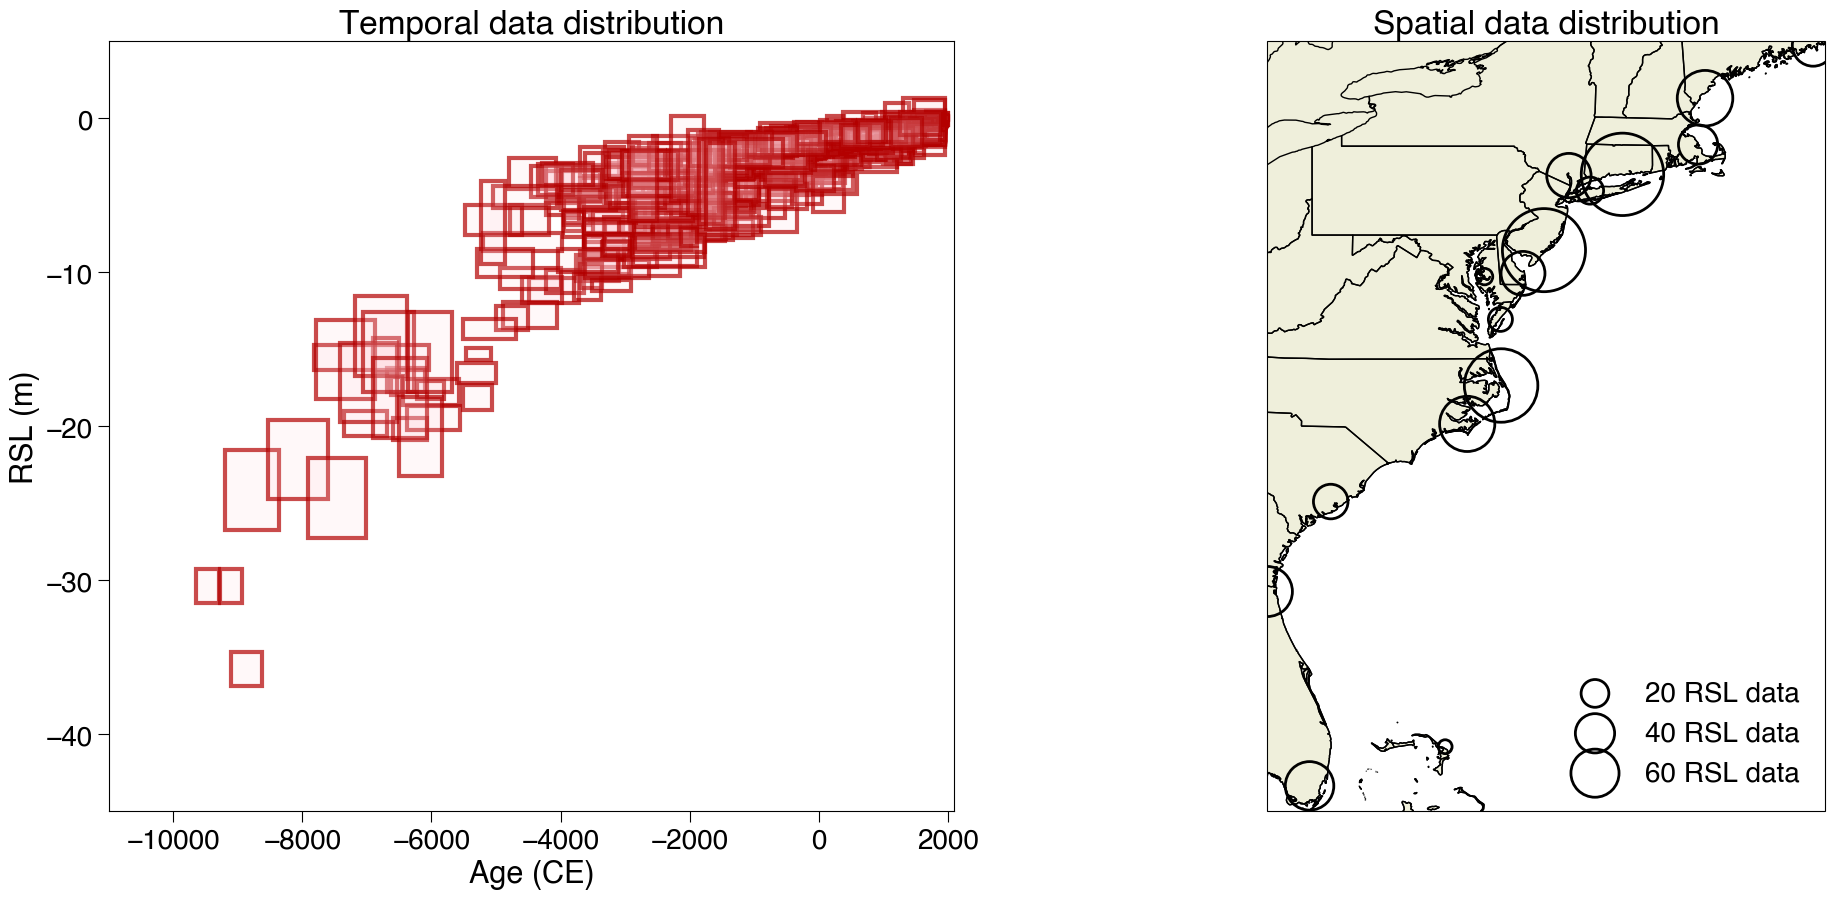

In [7]:
#load data
#ml is marine limiting data, tl is terrestrial limiting data, SLIP is sea-level index points
ml, SLIP, tl = PSTHM.load.load_regional_rsl_data('../../Data/US_Atlantic_Coast_for_ESTGP.csv',CE=True)
age, y, y_sigma, age_sigma, rsl_lon,rsl_lat, rsl_region = SLIP
#define input matrix
rsl_coord = torch.tensor(np.vstack((rsl_lat,rsl_lon)).T)
X = torch.hstack([age[:,None],rsl_coord]) 

#--------Plot data distribution----------------
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, :1])
PSTHM.plotting.plot_uncertainty_boxes(age,y, age_sigma*2,y_sigma*2,ax=ax,CE=True)
ax.set_xlim(-11000,2100)
ax.set_ylim(-45,5)
ax.set_title('Temporal data distribution')

#plot spatial data distribution, note that the size of the circle is proportional to the number of data points in the region
ax2 = fig.add_subplot(gs[0, 1:2], projection=ccrs.PlateCarree())

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.set_extent([np.min(rsl_lon),np.max(rsl_lon),np.min(rsl_lat),np.max(rsl_lat)])
rsl_region_index = [np.where(rsl_region==i)[0] for i in np.unique(rsl_region)]
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*20 for x in rsl_region_index],marker='o',facecolor='none',ec='k',
           linewidth=2)
sc = ax2.scatter([0],[0],s=400,label='20 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc2 = ax2.scatter([0],[0],s=800,label='40 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)
sc3 = ax2.scatter([0],[0],s=1200,label='60 RSL data',marker='o',facecolor='none',ec='k',zorder=-20,
           linewidth=2)

ax2.legend(handles=[sc,sc2,sc3], labels=['20 RSL data','40 RSL data','60 RSL data'], loc = 4)

ax2.set_title('Spatial data distribution');

In specific, we will use a global temporal kernel, a regionally linear ST kernel, a regional non-linear ST kernel, a locally non-linear ST kernel and a whitenoise kernel. We can write it down as:

$$
p(f| \Theta_{s},f ) \sim GP(0,k_{combined}(X,X')) \\
k_{combined}(X,X') = k_{global}(t,t') + k_{regionL}(X,X')  + k_{regionNL}(X,X') + k_{localNL}(X,X') + k_{whitenoise}(X,X')$$
where $X$ indicates time and location of each sea-level data, consisting time ($t$) and location ($x$). Each specific kernel can be expressed as: 
$$
k_{global}(t,t') = k_{M_{32}}(t,t')\\
k_{regionL}(X,X') = k_{Linear}(t,t') \cdot k_{RBF}(x,x')\\
k_{regionNL}(X,X') = k_{M_{52}}(t,t') \cdot k_{M_{32}}(x,x')\\
k_{localNL}(X,X') = k_{M_{32}}(t,t') \cdot k_{M_{32}}(x,x')\\
k_{whitenoise}(X,X') = k_{whitenose}(X,X')\\
$$
where $\cdot$ indicates element-wise multiplication. The difference between regional and local non-linear kernel is specified by different choices in kernels and prior distribtuions. 

**P.S.** 

1. The default code does not train the model, instead, it will load the trained model, which is much faster. If you want to try to train it on your own computer, just de-comment the code. 

2. To use GPU to accelerate the training process with `SVI_NI_optm` function, we need to specific `gpu==True` as well. 

In [3]:
import time

st = time.time() 

pyro.clear_param_store()
#define global temporal kernel as a Matern32
global_kernel = PSTHM.kernels.Matern32(input_dim=1,geo=False)
global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(20000.)))
global_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.01**2), torch.tensor(1000.)))

#define regionally non-linar spatio-temporal kernel
regional_nl_temporal_kernel = PSTHM.kernels.Matern32(input_dim=1,geo=False)
regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(500.), torch.tensor(5000.)))
regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.05), torch.tensor(100.)))
regional_nl_spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.25)))
regional_nl_kernel = PSTHM.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

#define locally non-linar spatio-temporal kernel
local_nl__temporal_kernel = PSTHM.kernels.Matern32(input_dim=1,geo=False)
local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))
local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.1**2), torch.tensor(10.)))
local_nl__spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.05)))
local_nl_kernel = PSTHM.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

#define whitenoise kernel
whitenoise_kernel = PSTHM.kernels.WhiteNoise(input_dim=1)
whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.01**2),torch.tensor(100.)))

#combine all kernels
combined_sp_kernel = PSTHM.kernels.Sum(regional_nl_kernel,local_nl_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,global_kernel)

gpr_1 = PSTHM.model.GPRegression_V(X, y, combined_sp_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
# gpr,track_list = PSTHM.opti.SVI_NI_optm(gpr,x_sigma=age_sigma,num_iteration=150,lr=0.2,decay_r = 0.8,step_size=50)

# axes = PSTHM.plotting.plot_track_list(track_list)


# et = time.time() # get the end time

# # get the execution time
# elapsed_time = et - st
# print('Execution time: {:3.3f} s'.format( elapsed_time))

# # ----Save and load the trained model----
# pyro.get_param_store().save("../../Trained_Models/Holocene_SP_model.pt")

#-----------Load traniend model and plot the result----------------
pyro.get_param_store().load("../../Trained_Models/Holocene_SP_model.pt")


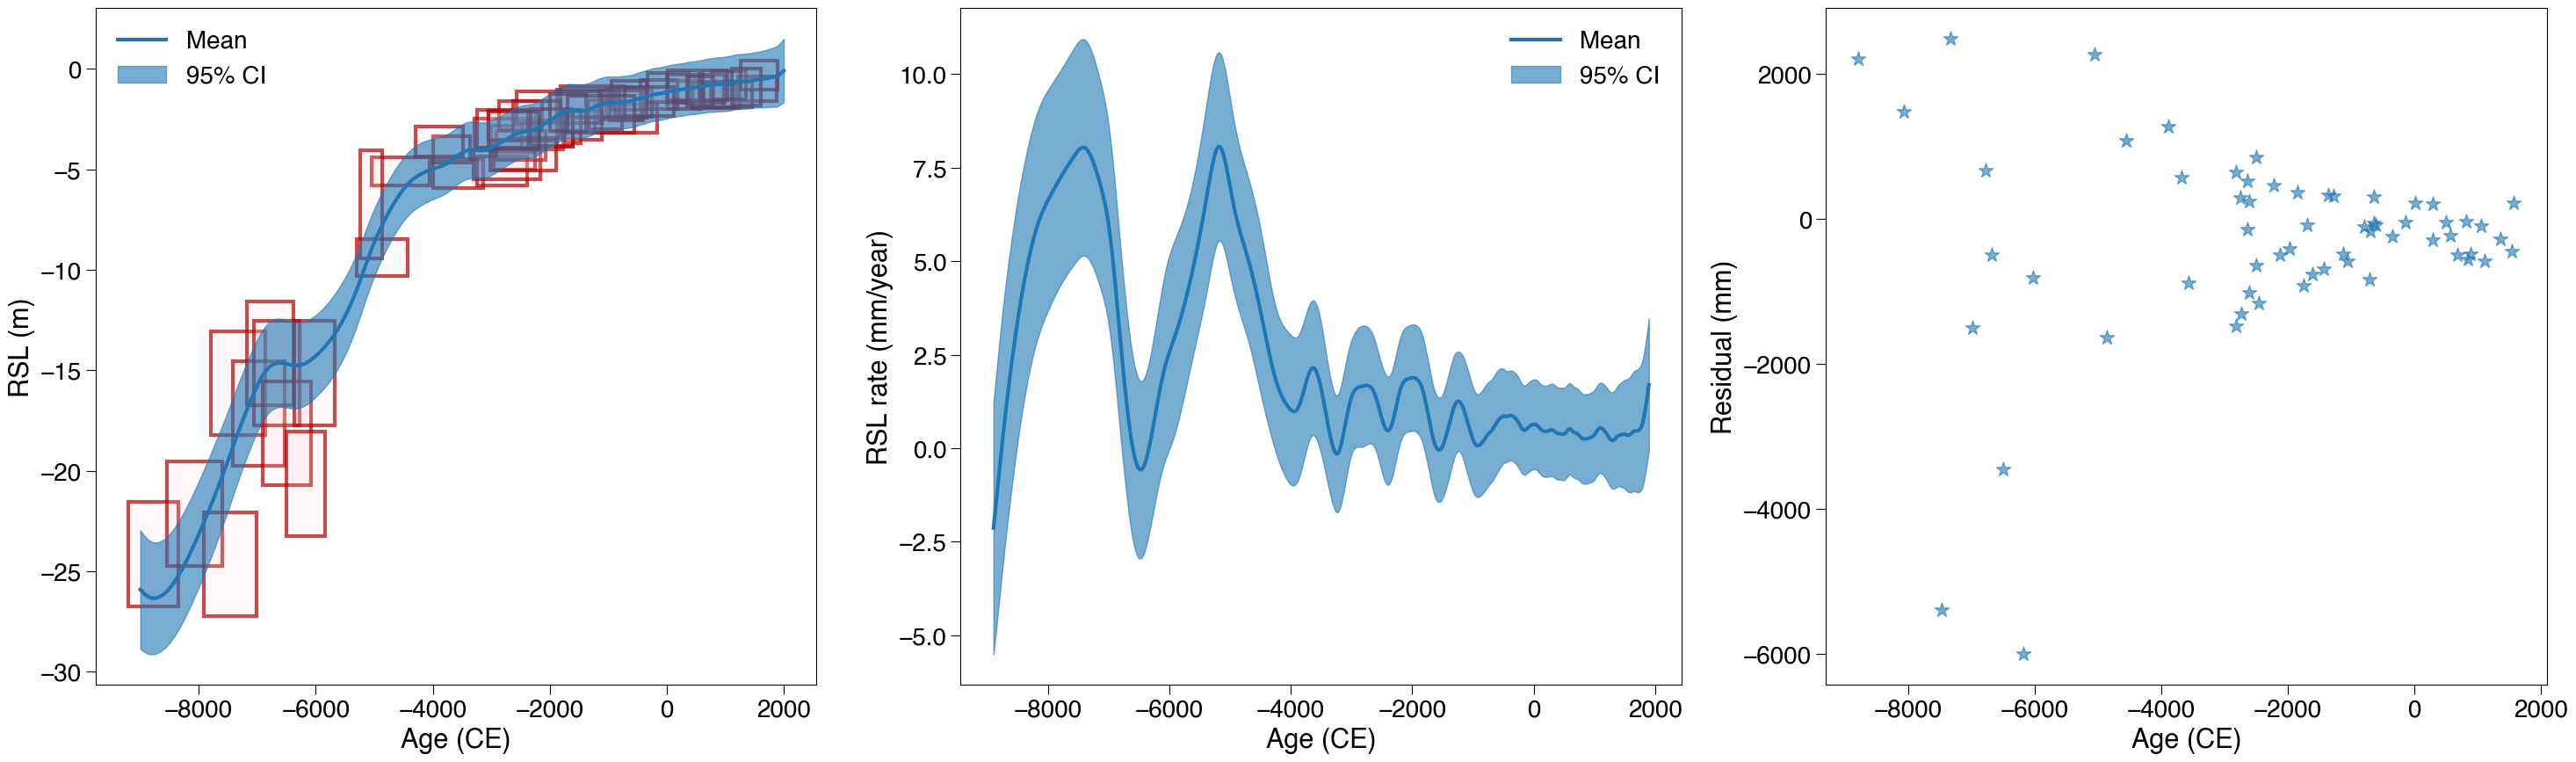

In [4]:
#generate prediction matrix
NJ_index = rsl_region==15
test_age = np.arange(-9000,2010,10)
pred_matrix = PSTHM.post.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean_1, y_var_1 = gpr_1(pred_matrix.double(), full_cov=True)
y_std_1 = y_var_1.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(test_age,y_var_1.cpu().detach().numpy(),y_mean_1.cpu().detach().numpy())

#plot the prediction
axes = PSTHM.plotting.plot_tem_regression(age[NJ_index],y[NJ_index],age_sigma[NJ_index],y_sigma[NJ_index],test_age,y_mean_1.detach().numpy(),y_std_1.detach().numpy(),
                          rsl_time,rsl_rate,rsl_rate_sd )


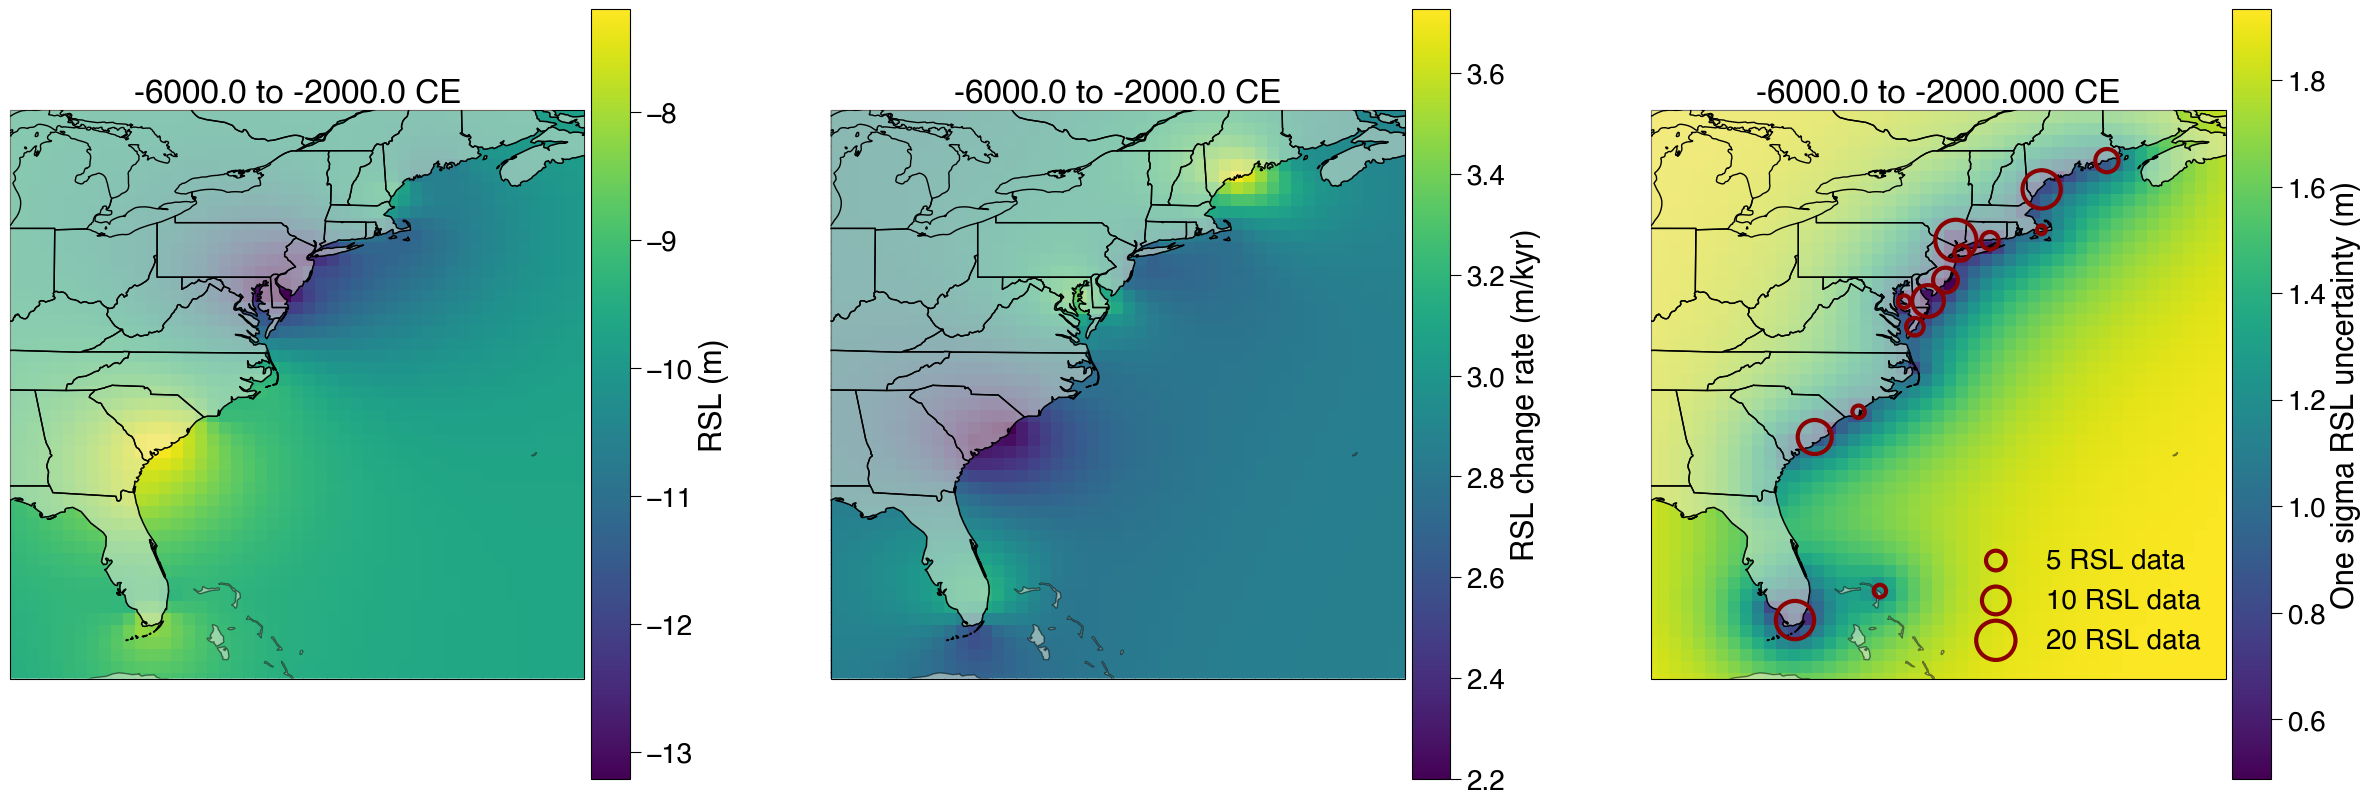

In [5]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-5,np.max(rsl_lon)+5,0.5)
#from 10000 to 8000 with 500 years interval, don't use over small time interval, otherwise the prediction will be very slow
#and the required RAM will be pretty large 
time_mat = np.arange(-6000,-1900,4000) 
pred_matrix = PSTHM.post.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)

y_mean, y_var = gpr_1(pred_matrix, full_cov=True)
pred_matrix_2 = PSTHM.post.gen_pred_matrix([-5500],lat_matrix,lon_matrix)
y_mean_spa_1, y_var_spa_1 = gpr_1(pred_matrix_2, full_cov=True)
y_std_spa_1 = y_var_spa_1.diag().sqrt()
fig = PSTHM.plotting.plot_spatial_rsl_range(pred_matrix,y_mean,y_var,rsl_lon,rsl_lat,age,rsl_region,cmap='viridis',plot_site=True)


#### Kernel decompositions


In [6]:
NJ_index = rsl_region==15
test_age = np.arange(-10000,2010,10)
pred_matrix = PSTHM.post.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean, y_var = gpr_1(pred_matrix, full_cov=True)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr_1.kernel.kern1
regional_nl_kernel = gpr_1.kernel.kern0.kern0.kern0
local_nl_kernel = gpr_1.kernel.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,regional_nl_dep,local_nl_dep = PSTHM.post.decompose_kernels(gpr_1,pred_matrix,[global_kernel,regional_nl_kernel,local_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()

local_nl_mean,local_nl_var = local_nl_dep
local_nl_std = local_nl_var.diag().sqrt()


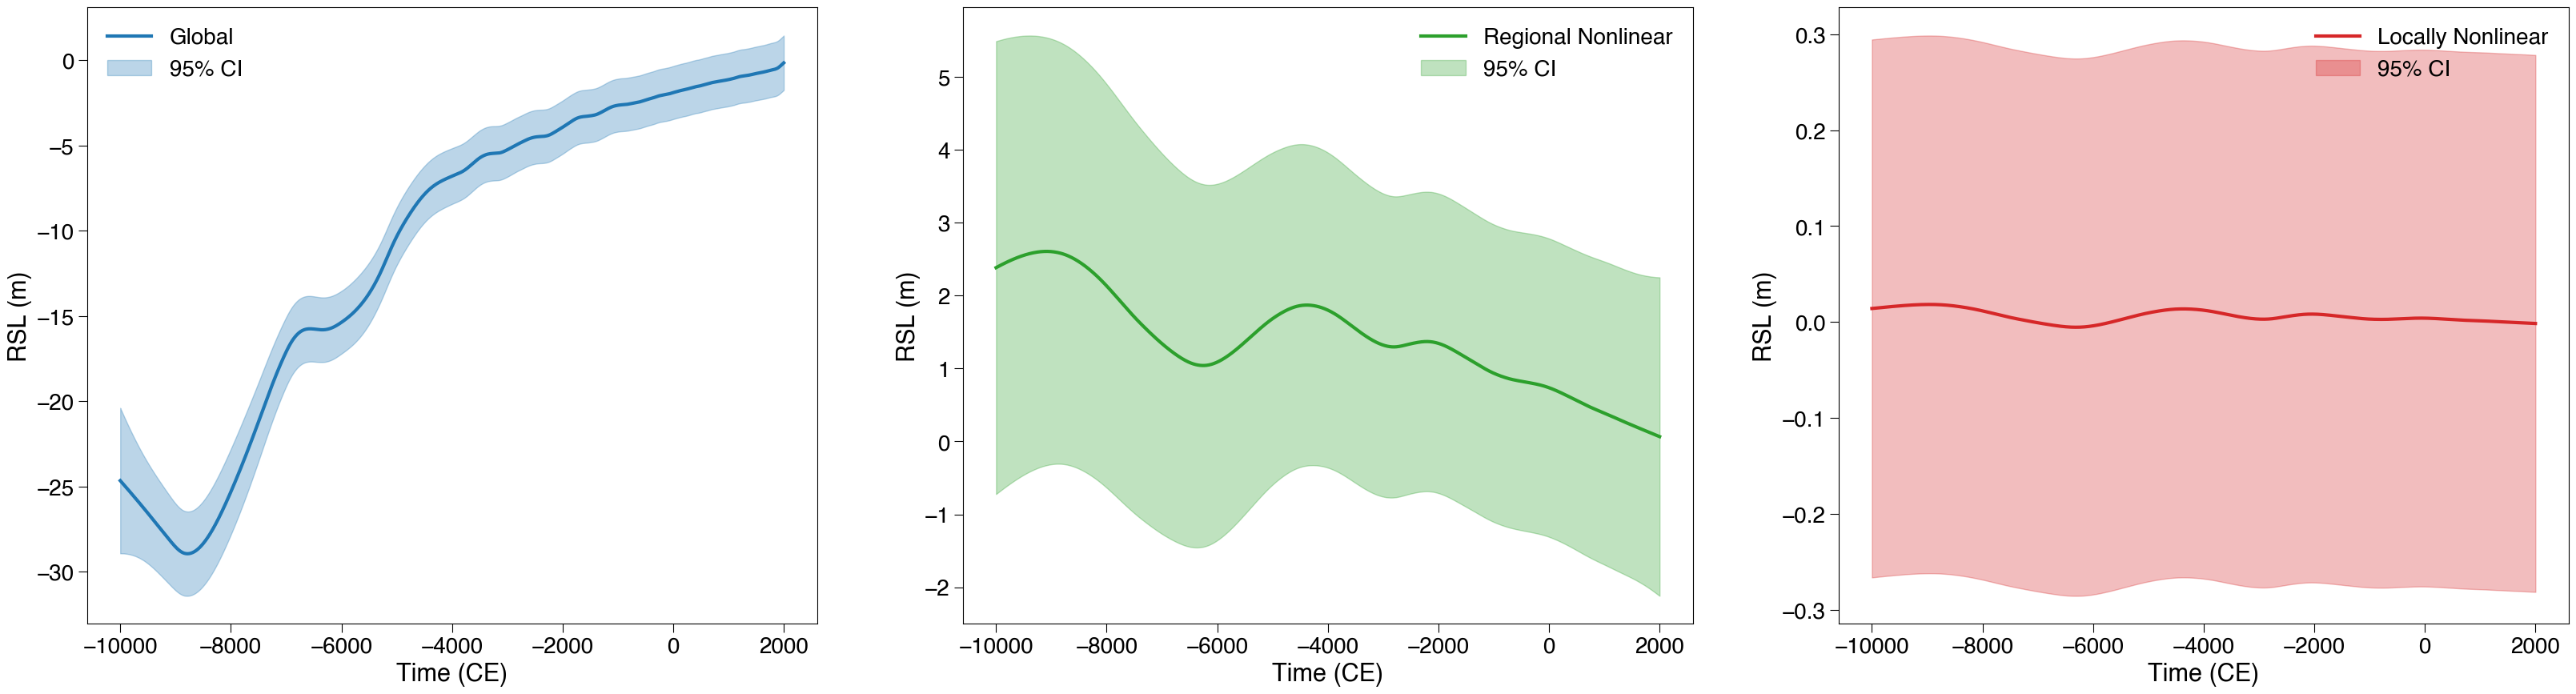

In [7]:
plt.figure(figsize=(40,10))
ax = plt.subplot(131)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')

plt.xlabel('Time (CE)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(132)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (CE)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(133)
plt.plot(test_age,local_nl_mean.detach().numpy(),'C3',linewidth=3,label='Locally Nonlinear')
plt.fill_between(test_age,local_nl_mean.detach().numpy()-2*local_nl_std.detach().numpy(),local_nl_mean.detach().numpy()+2*local_nl_std.detach().numpy(),color='C3',alpha=0.3,label='95% CI')
plt.xlabel('Time (CE)')
plt.ylabel('RSL (m)')
plt.legend();

In [8]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-5,np.max(rsl_lon)+5,0.5)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.post.gen_pred_matrix([-10000],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.post.gen_pred_matrix([2000],lat_matrix,lon_matrix)

#-----------------define the kernel to decompose-----------------
global_kernel = gpr_1.kernel.kern1
regional_nl_kernel = gpr_1.kernel.kern0.kern0.kern0
local_nl_kernel = gpr_1.kernel.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
regional_nl_dep,local_nl_dep = PSTHM.post.decompose_kernels(gpr_1,pred_matrix,[regional_nl_kernel,local_nl_kernel])
regional_nl_dep2,local_nl_dep2 = PSTHM.post.decompose_kernels(gpr_1,pred_matrix2,[regional_nl_kernel,local_nl_kernel])

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_mean2,regional_nl_var2 = regional_nl_dep2
regional_nl_std = regional_nl_var.diag().sqrt()
regional_nl_std2 = regional_nl_var2.diag().sqrt()

local_nl_mean,locall_nl_var = local_nl_dep
local_nl_mean2,local_nl_var2 = local_nl_dep2
local_nl_std = local_nl_var.diag().sqrt()
local_nl_std2 = local_nl_var2.diag().sqrt()


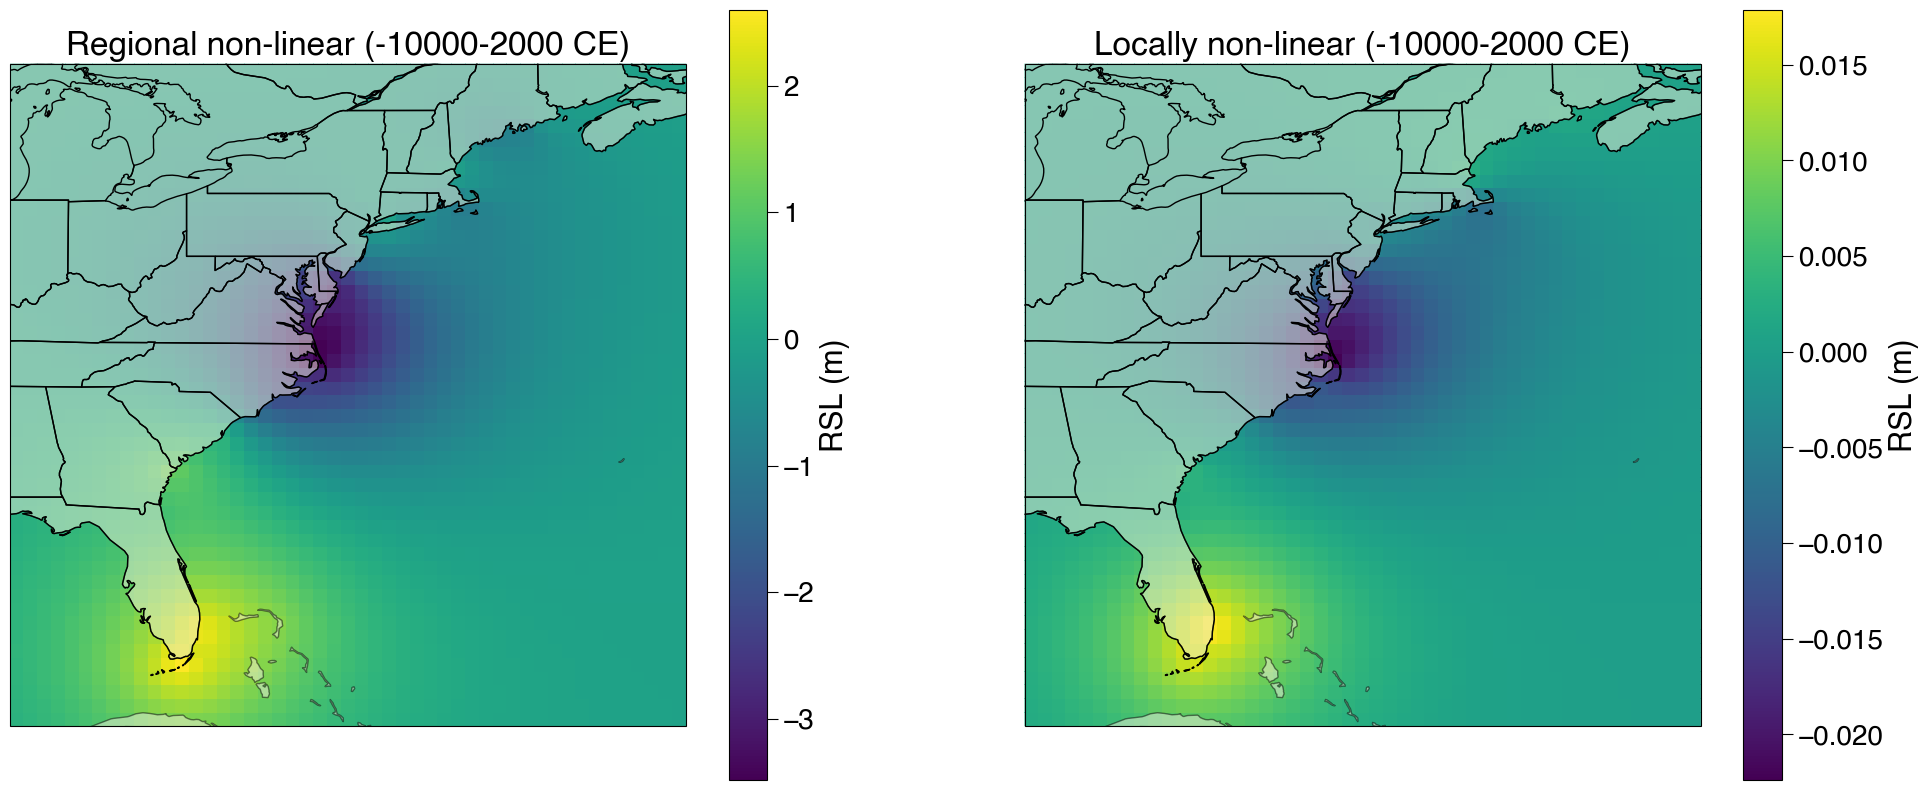

In [9]:
plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)

im = ax2.pcolor(lon_mat,lat_mat,(regional_nl_mean-regional_nl_mean2).detach().numpy().reshape(lat_mat.shape),zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Regional non-linear (-10000-2000 CE)')

ax2 = plt.subplot(122,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)

im = ax2.pcolor(lon_mat,lat_mat,(local_nl_mean-local_nl_mean2).detach().numpy().reshape(lat_mat.shape),zorder=-1)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Locally non-linear (-10000-2000 CE)');

By decomposing different STGP kernels, we can start to identify some phyiscal processes of postglacial sea-level change. We can see that regional linear kernel cause sea-level fall in the north and sea-level rise in the south, which can relate to glacial isostatic adjustment, tectonic and sediment compaction. The regional and locally non-linear terms usually used to describe ocean/atmosphere dynamics and static equilibrium “fingerprint” effects. 

### 2. STGP with a single physical model for Holocene sea-level data

As suggested by many paleo sea-level studies that the majority of sea-level change from the Last Glacial Maximum (~21,000 years ago) can be explained by ice-ocean mass exchange induced gravitational, rotational and deformational (GRD) effects on sea-level change, whcih can be modelled by a glacial isostatic adjustment (GIA) model. 

In this case, we can write our model as:
$$
p(f| \Theta_{s},\Theta_{g},f) \sim GP(GIA(X| \Theta_{g}),k_{combined}(X,X'))
$$
where $\Theta_{g}$ indicates GIA model parameters, including global ice history and Earth rheology; and GIA(X) indicates GIA model output for specific location and time, which can be interpreted as a interpolation function producing sea-level predictions for any given location and time. 

Let's try to predict sea level based on ICE_7G ice model as VM5 Earth rheology model, which can be downloaded [here](https://www.atmosp.physics.utoronto.ca/~peltier/data.php). You can see the GIA model prediction on global sea level on the figure below. Based on physical simulation, we can see more pattern of sea-level change for regional far-away from sea-level data. Although physical model can predict global sea level, the predicted sea-level can also fail to explain the observed sea-level data due to missing physical law, under constrained physical parameters etc... This can be evident when we check the data-model misfit in the right figure below.


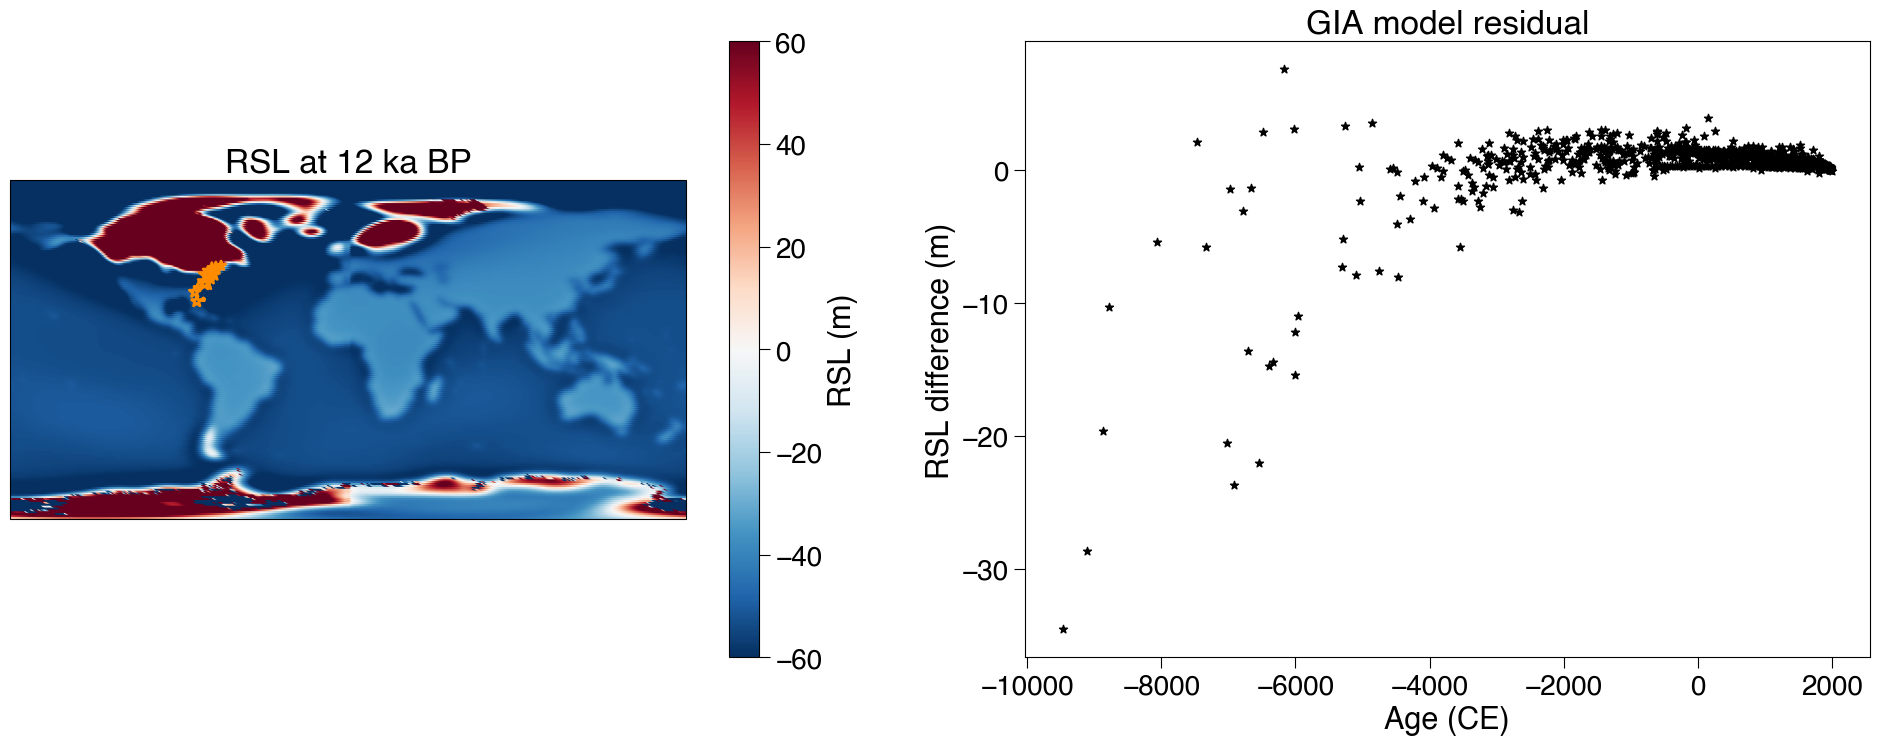

In [8]:
lat = np.arange(-89.5,90,1)
lon = np.arange(0.5,360,1)
times = np.arange(0,13)
lon_matrix_GIA,lat_matrix_GIA = np.meshgrid(lon,lat)
ice7g_rsl = np.load('ice7g_rsl.npy')
#select which time to visualize
time_index = 12
#-------Interpolate GIA model to RSL locations
from scipy.interpolate import RegularGridInterpolator as rgi
#transfer GIA model age to CE
time_CE = -(times*1000-1950)+67
time_mat,lat_mat,lon_mat = np.meshgrid(time_CE,lat,lon)
#interpolate GIA model
ice7g_interp = rgi((time_CE[::-1],lat,lon), ice7g_rsl[::-1])
#transfer longitude from -180-180 to 0-360
X_new = torch.clone(X)
X_new[:,2]+=360
ice7g_pred = ice7g_interp(X_new)

#---------------------------------------------------------
fig = plt.figure(figsize=(24,8))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())

im = ax2.scatter(lon_matrix_GIA,lat_matrix_GIA,c = ice7g_rsl[time_index],cmap='RdBu_r',zorder=0,vmax = 60,vmin=-60)
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*1 for x in rsl_region_index],marker='*',facecolor='none',ec='darkorange',
           linewidth=2)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('RSL at {:} ka BP'.format(time_index))

plt.subplot(122)
plt.scatter(X_new[:,0],ice7g_pred-y.cpu().detach().numpy(),c='k',marker='*')
plt.xlabel('Age (CE)')
plt.ylabel('RSL difference (m)')
plt.title('GIA model residual');

In this case, we can use use GP model based on a physical model to improve the performance of paleo sea-level. To implement GP with a single GIA model, we are essentially training the GP model with the GIA model residual (instead of original RSL data). As GIA model can be used to describe global and regional linear trend, we can re-write our combined kernel to:
$$
k_{combined}(X,X') = k_{localNL}(X,X') + k_{whitenoise}(X,X')
$$


  0%|          | 0/150 [00:00<?, ?it/s]

Execution time: 42.773 s


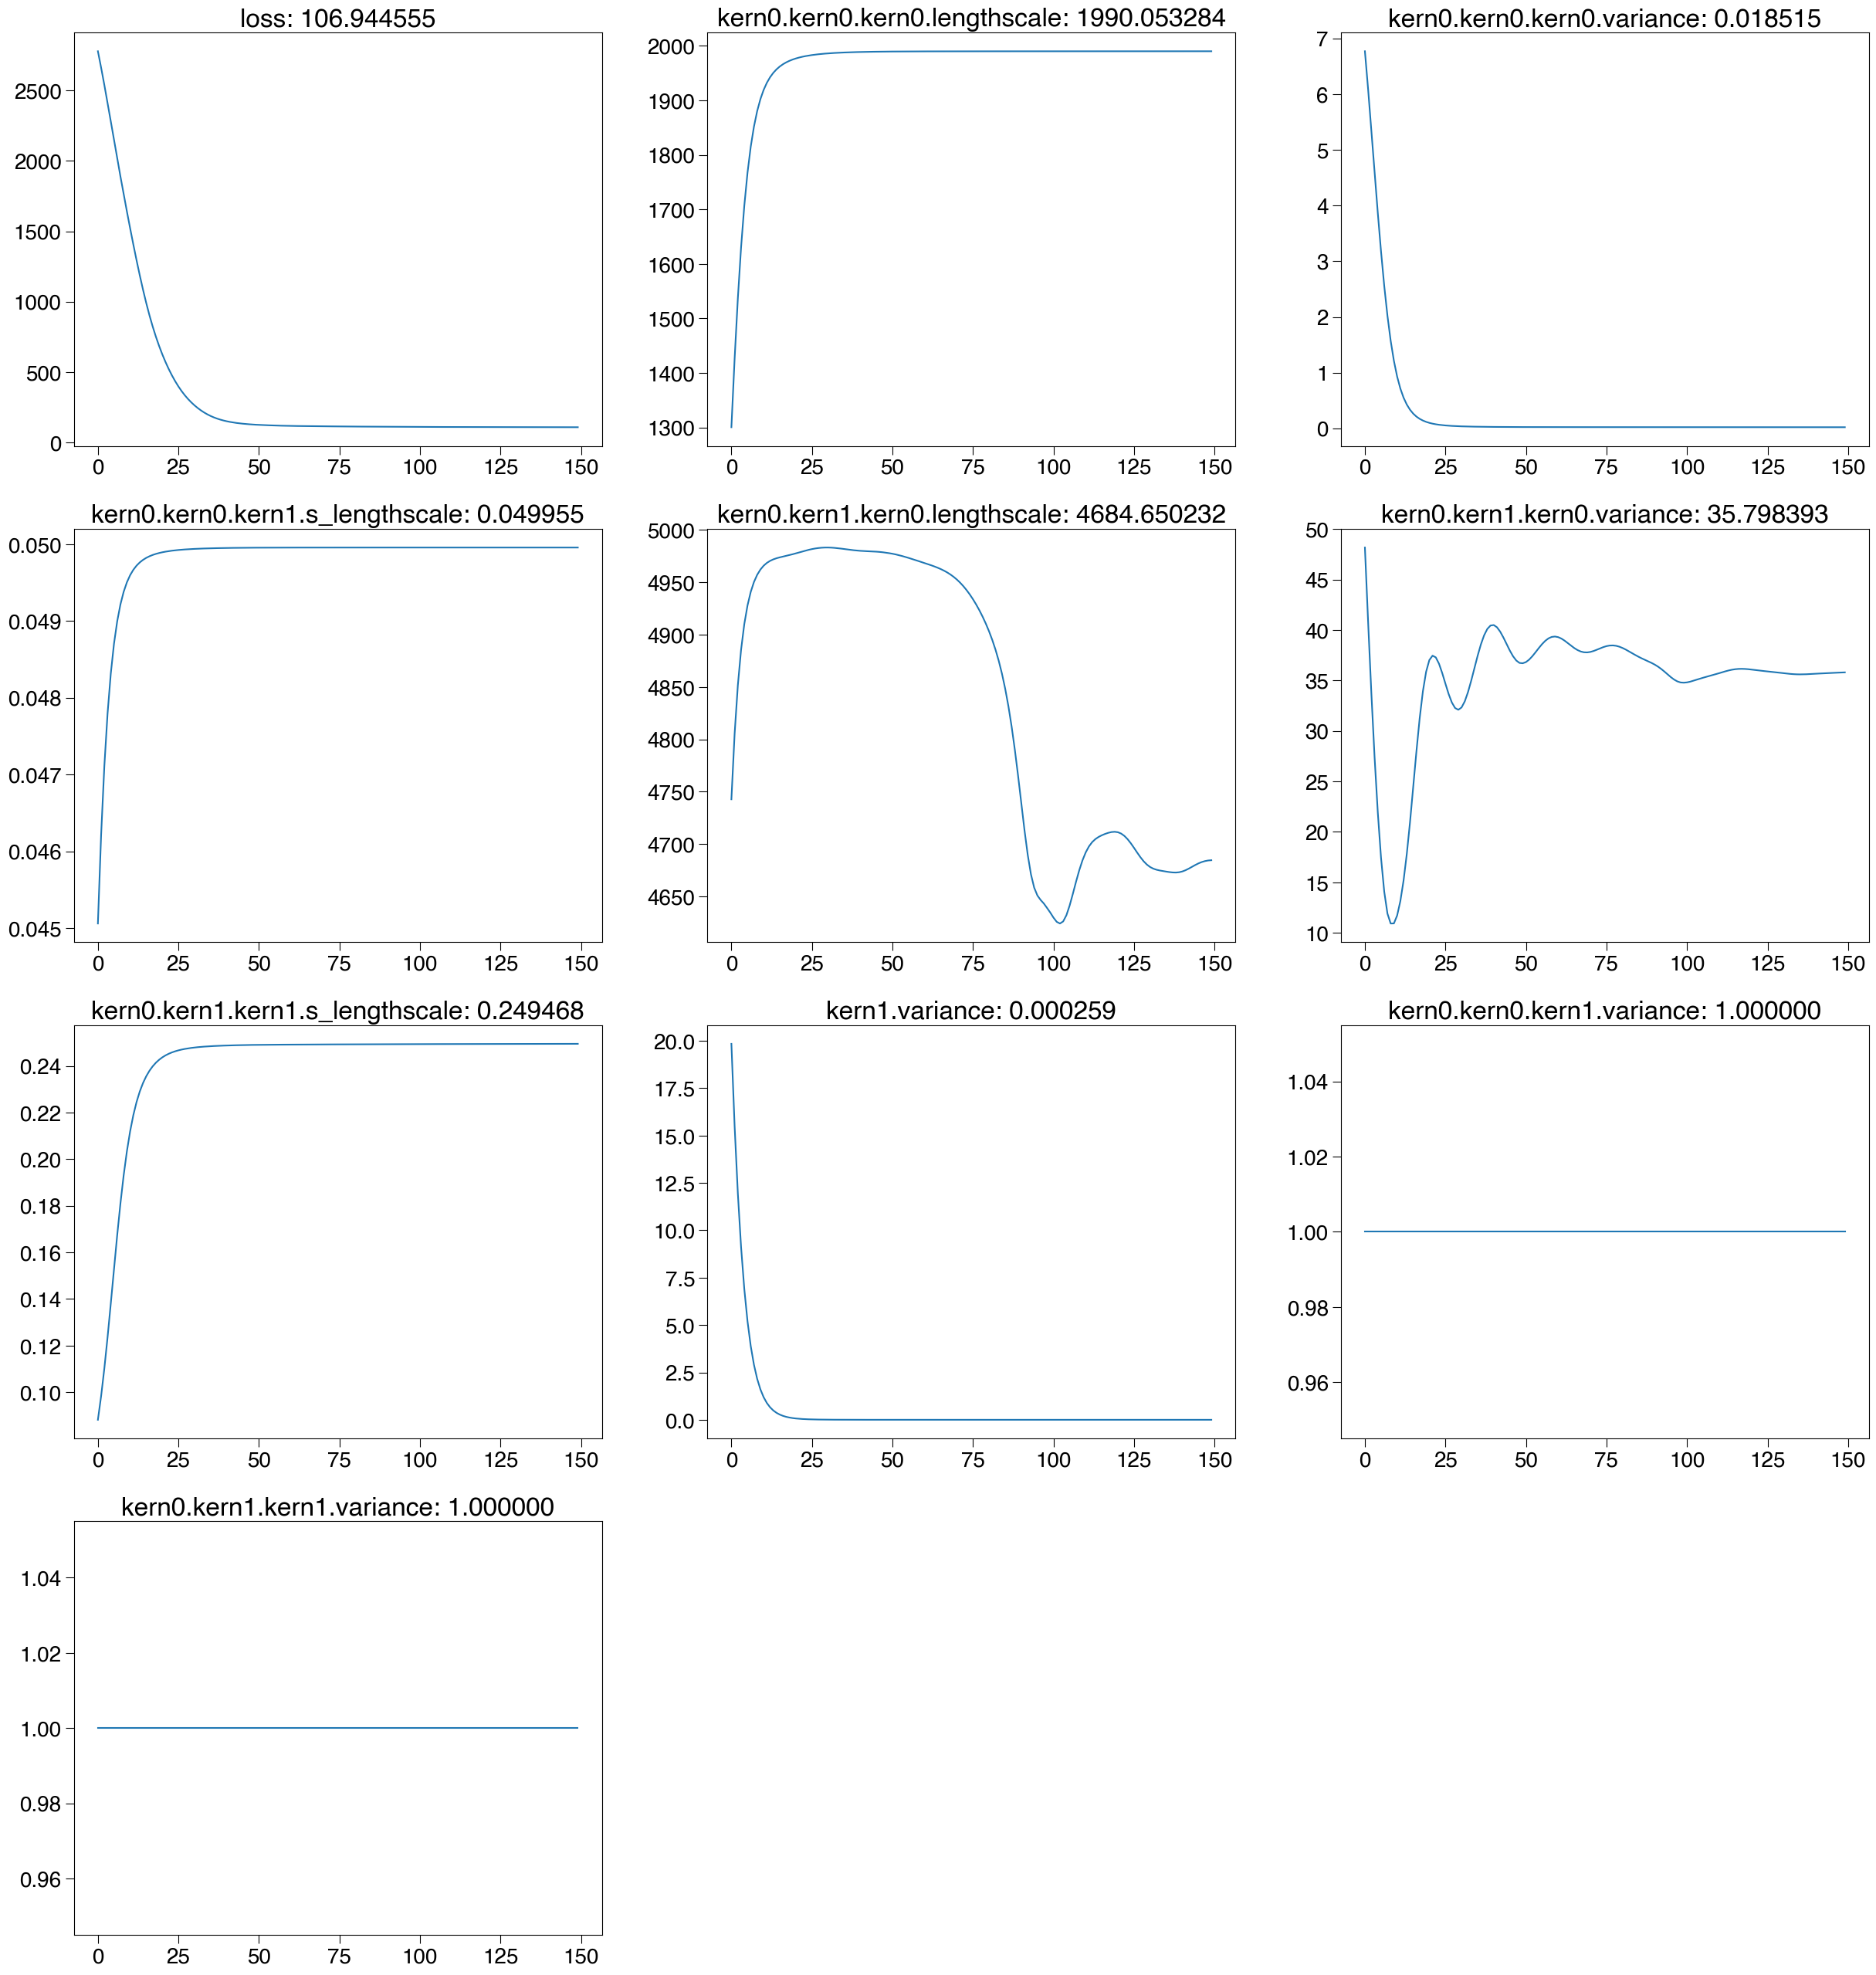

In [11]:
import time
st = time.time() 

# pyro.clear_param_store()
#define regionally non-linar spatio-temporal kernel
regional_nl_temporal_kernel = PSTHM.kernels.Matern32(input_dim=1,geo=False)
regional_nl_temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(500.), torch.tensor(5000.)))
regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.05), torch.tensor(100.)))
regional_nl_spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.25)))
regional_nl_kernel = PSTHM.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

#define locally non-linar spatio-temporal kernel
local_nl__temporal_kernel = PSTHM.kernels.Matern32(input_dim=1,geo=False)
local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))
local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.1**2), torch.tensor(10.)))
local_nl__spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.05)))
local_nl_kernel = PSTHM.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

#define whitenoise kernel
whitenoise_kernel = PSTHM.kernels.WhiteNoise(input_dim=1)
whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.01**2),torch.tensor(100.)))

#combine all kernels
combined_sp_kernel = PSTHM.kernels.Sum(local_nl_kernel,regional_nl_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,whitenoise_kernel)

y_residual = torch.tensor(y.cpu().detach().numpy() - ice7g_pred).double()
gpr_2 = PSTHM.model.GPRegression_V(X_new, y_residual, combined_sp_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr_2,track_list = PSTHM.opti.SVI_NI_optm(gpr_2,x_sigma=age_sigma,num_iteration=150,lr=0.3,decay_r = 0.8,step_size=50)

axes = PSTHM.plotting.plot_track_list(track_list)
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

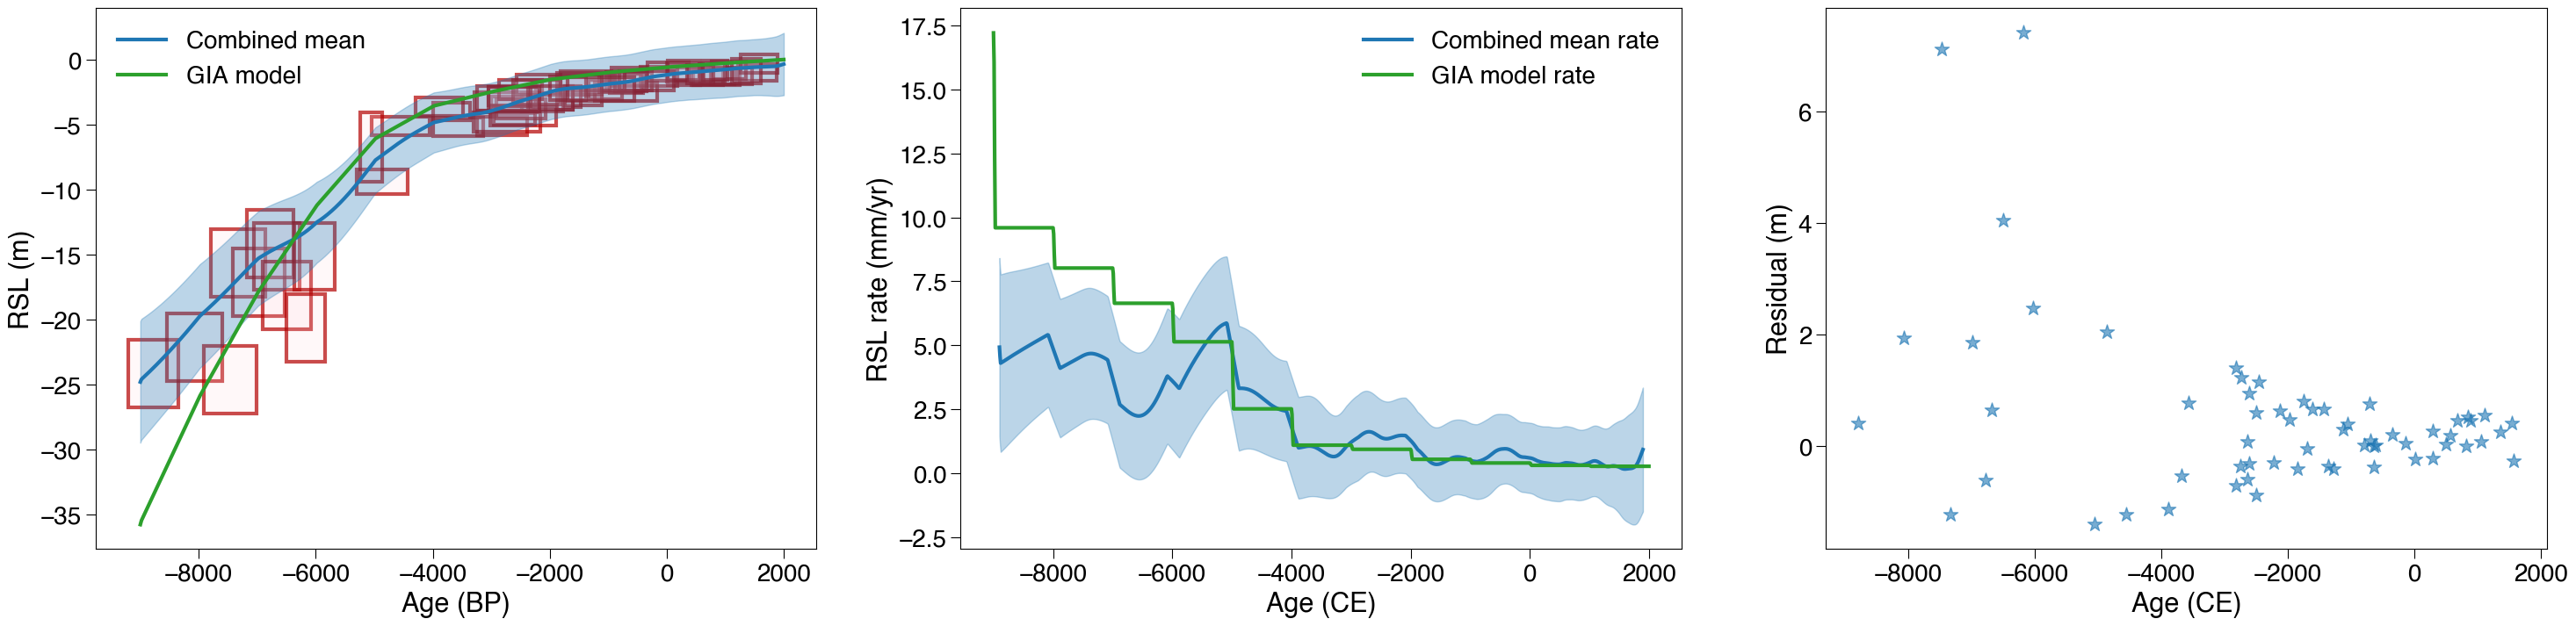

In [515]:
#generate prediction matrix
NJ_index = rsl_region==15
test_age = np.arange(-9000,2010,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
y_mean_2, y_var_2 = gpr_2(pred_matrix.double(), full_cov=True)
pred_matrix[:,2]+=360
GIA_pred = torch.tensor(ice7g_interp(pred_matrix))
y_combined= y_mean_2 + GIA_pred
y_std_2 = y_var_2.diag().sqrt()
rsl_time,rsl_rate_2,rsl_rate_sd_2 = PSTHM.cal_rate_var(test_age,y_var_2.cpu().detach().numpy(),y_combined.cpu().detach().numpy())
GIA_model_rate = np.gradient(GIA_pred,test_age)

#plot the prediction
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plotting.plot_uncertainty_boxes(X[:,0][NJ_index],y[NJ_index], age_sigma[NJ_index]*2,y_sigma[NJ_index]*2,ax=ax)
plt.plot(test_age,y_combined.detach().numpy(),'C0',linewidth=3,label='Combined mean')
plt.fill_between(test_age,y_combined.detach().numpy()-2*y_std_2.detach().numpy(),y_combined.detach().numpy()+2*y_std_2.detach().numpy(),color='C0',alpha=0.3)
plt.plot(test_age,GIA_pred,'C2',linewidth=3,label='GIA model')
plt.legend()

plt.subplot(132)
plt.plot(rsl_time,rsl_rate_2*1000,'C0',linewidth=3,label='Combined mean rate')
plt.fill_between(rsl_time,(rsl_rate_2-2*rsl_rate_sd_2)*1000,(rsl_rate_2+2*rsl_rate_sd_2)*1000,color='C0',alpha=0.3)
plt.plot(test_age,GIA_model_rate*1000,'C2',linewidth=3,label='GIA model rate')
plt.legend()
plt.ylabel('RSL rate (mm/yr)')
plt.xlabel('Age (CE)')

plt.subplot(133)
f = interpolate.interp1d(test_age,y_combined.detach().numpy())
residual = f(X[:,0][NJ_index])-y[NJ_index].detach().numpy()
plt.scatter(X[:,0][NJ_index],residual,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (m)');

We can see that by combining the GIA and GP models, the final predictions now are influenced by physical model and observational data. Becuase GIA model is controlled by ice history, the resolution of which is typically very low, using GP can effectively help us to understand sea-level change with better temporal resolution.

We can further experience the effect of incorporating a GP with a GIA model when we doing spatial analysis. Let's plot the spatial distribution of RSL. 



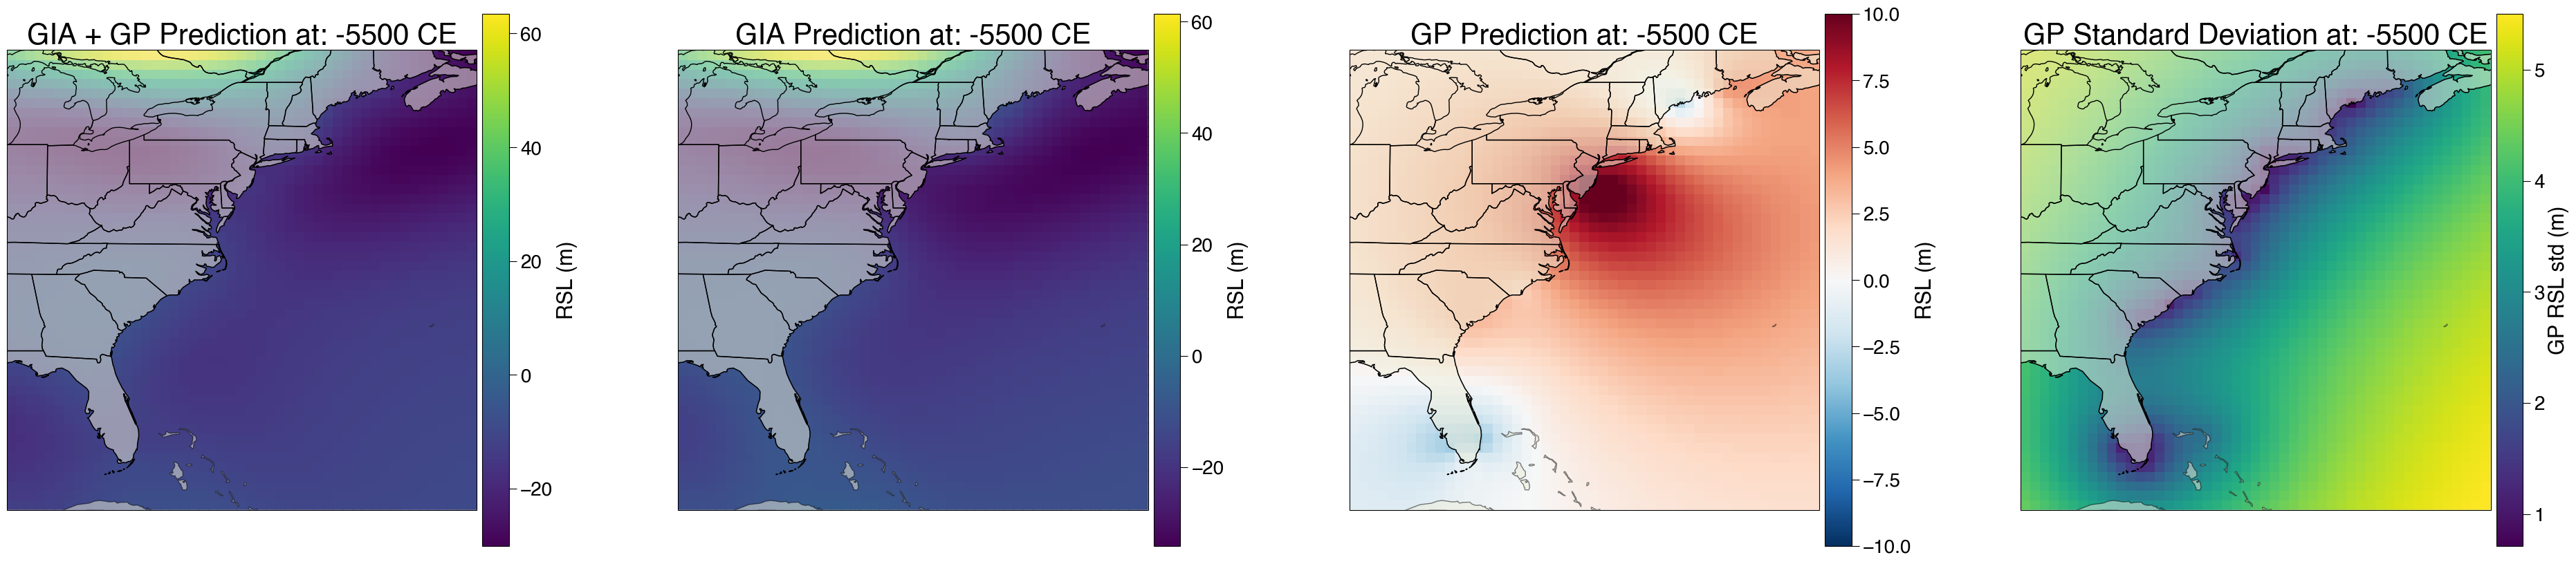

In [12]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-5,np.max(rsl_lon)+5,0.5)
time_mat = np.array([-5500]) 
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
pred_matrix[:,2]+=360
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
y_mean, y_var = gpr_2(pred_matrix, full_cov=True)
y_std_spa_2 = y_var.diag().sqrt()

GIA_pred_spa_2 = torch.tensor(ice7g_interp(pred_matrix))
y_combined_2= y_mean + GIA_pred_spa_2

#------------plot -----------------
plt.figure(figsize=(48,10))
ax2 = plt.subplot(141,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_combined_2.detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='viridis',zorder=-1)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA + GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(142,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,GIA_pred_spa_2.reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='viridis',zorder=-1)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(143,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_mean.detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=10,vmin=-10
                 ,zorder=-1)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(144,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_std_spa_2.detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='viridis',zorder=-1)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('GP RSL std (m)')
ax2.set_title('GP Standard Deviation at: {:} CE'.format(time_mat[0]),fontsize=30);

From the temporal analysis above we can find that the GIA prediction around New Jersey shows a RSL much lower than the observastions, in this case, GP predicts a strongly positive sea-level around New Jersey. Likewise, GIA prediction around Florida shows a RSL higher than the observations, therefore, GP model refines the sea level there. 

Compared to GP-only model, this combined approach shows a spatial sea-level pattern that is more consistent with sea-level physics. 

### 3. STGP with multiple physical models for Holocene sea-level data 

Given the hugh uncertainty in ice history and Earth rheology, using one GIA model output to describe the GRD signal is often not appropriate. To improve this, we can use probablistic approach to combined multiple GIA model together, which is introduced in Tutorial 2. Let's try to use ice model from [Gowan et al., 2021](https://www.nature.com/articles/s41467-021-21469-w) with 1-D Earth rheology model with 71 km lithosphere, 0.3 and 70 x 10 $^{21}$ Pa s upper and lower mantle viscosity to describe an alternative sea-level pattern. 

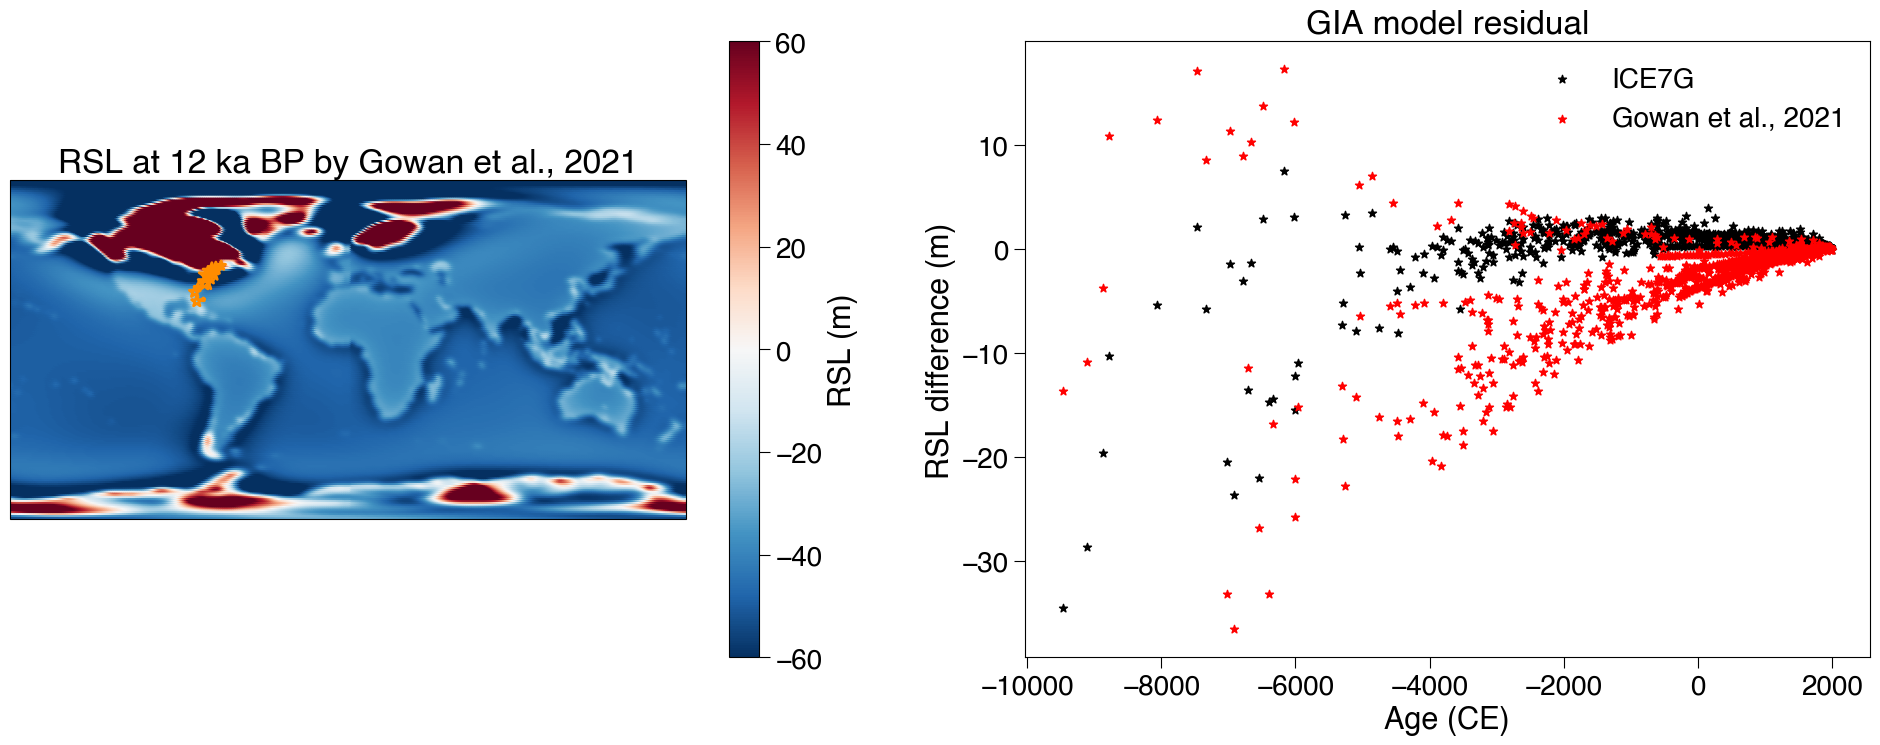

In [9]:
gowan_rsl = np.load('gowan_rsl.npy')
#interpolate GIA model
gowan_interp = rgi((time_CE[::-1],lat,lon), gowan_rsl[::-1])
#transfer longitude from -180-180 to 0-360
gowan_pred = gowan_interp(X_new)

time_index = 12 
#---------------------------------------------------------
fig = plt.figure(figsize=(24,8))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())

im = ax2.scatter(lon_matrix_GIA,lat_matrix_GIA,c = gowan_rsl[time_index],cmap='RdBu_r',zorder=0,vmax = 60,vmin=-60)
ax2.scatter([np.mean(rsl_lon[x]) for x in rsl_region_index], [np.mean(rsl_lat[x]) for x in rsl_region_index],
           transform=ccrs.PlateCarree(),s=[len(x)*1 for x in rsl_region_index],marker='*',facecolor='none',ec='darkorange',
           linewidth=2)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('RSL at {:} ka BP by Gowan et al., 2021'.format(time_index))

plt.subplot(122)
plt.scatter(X_new[:,0],ice7g_pred-y.cpu().detach().numpy(),c='k',marker='*',label='ICE7G')
plt.scatter(X_new[:,0],gowan_pred-y.cpu().detach().numpy(),c='r',marker='*',label='Gowan et al., 2021')

plt.xlabel('Age (CE)')
plt.ylabel('RSL difference (m)')
plt.title('GIA model residual')
plt.legend();

You can clearly see some difference between these two models, where sea-level prediction by Gowan et al., 2021 significantly underestimate the true sea level change, which can be a result of Earth rheology model used here is not suitable for this ice model. But Let's try to predict GIA-induced sea-level change as in tutorial 2:
$$
f_{GIA}(x,t) = s \times \sum_{p=1}^{n}w_{p}GIA(x,t| I_{p},E_{p})
$$

where $w_{p}$ indicates weighted parameters for each physical model set and $n$ denotes the number of tested physical parameters:
$$
w_{p} \sim Dir(1)\\
$$
where $Dir$ indicates a a Dirichlet distribution, which is used to generate random weighting factors that fulfil the conditions $\sum_{p=1}^{n} w_{p} = 1$ and $w_{p} >0$; 1 is a hyperparameter that describes the concentration of random samples.

$s$ is a sclaring parameter to scale the GIA preidction:
$$
s \sim N(1,0.15)
$$

To input GIA models as mean function for GP model, we need to input the interpolation functions of GIA models to GP model. Check the example code below!

**P.S.** The default code does not train the model, instead, it will load the trained model, which is much faster. If you want to try to train it on your own computer, just de-comment the code. 

  0%|          | 0/300 [00:00<?, ?it/s]

Execution time: 54.537 s
local non-linear kernel lengthscale: 3090.189, s_lengthscale 0.300, variance: 17.947
w_0: 0.23, w_1: 0.77
s: 0.45


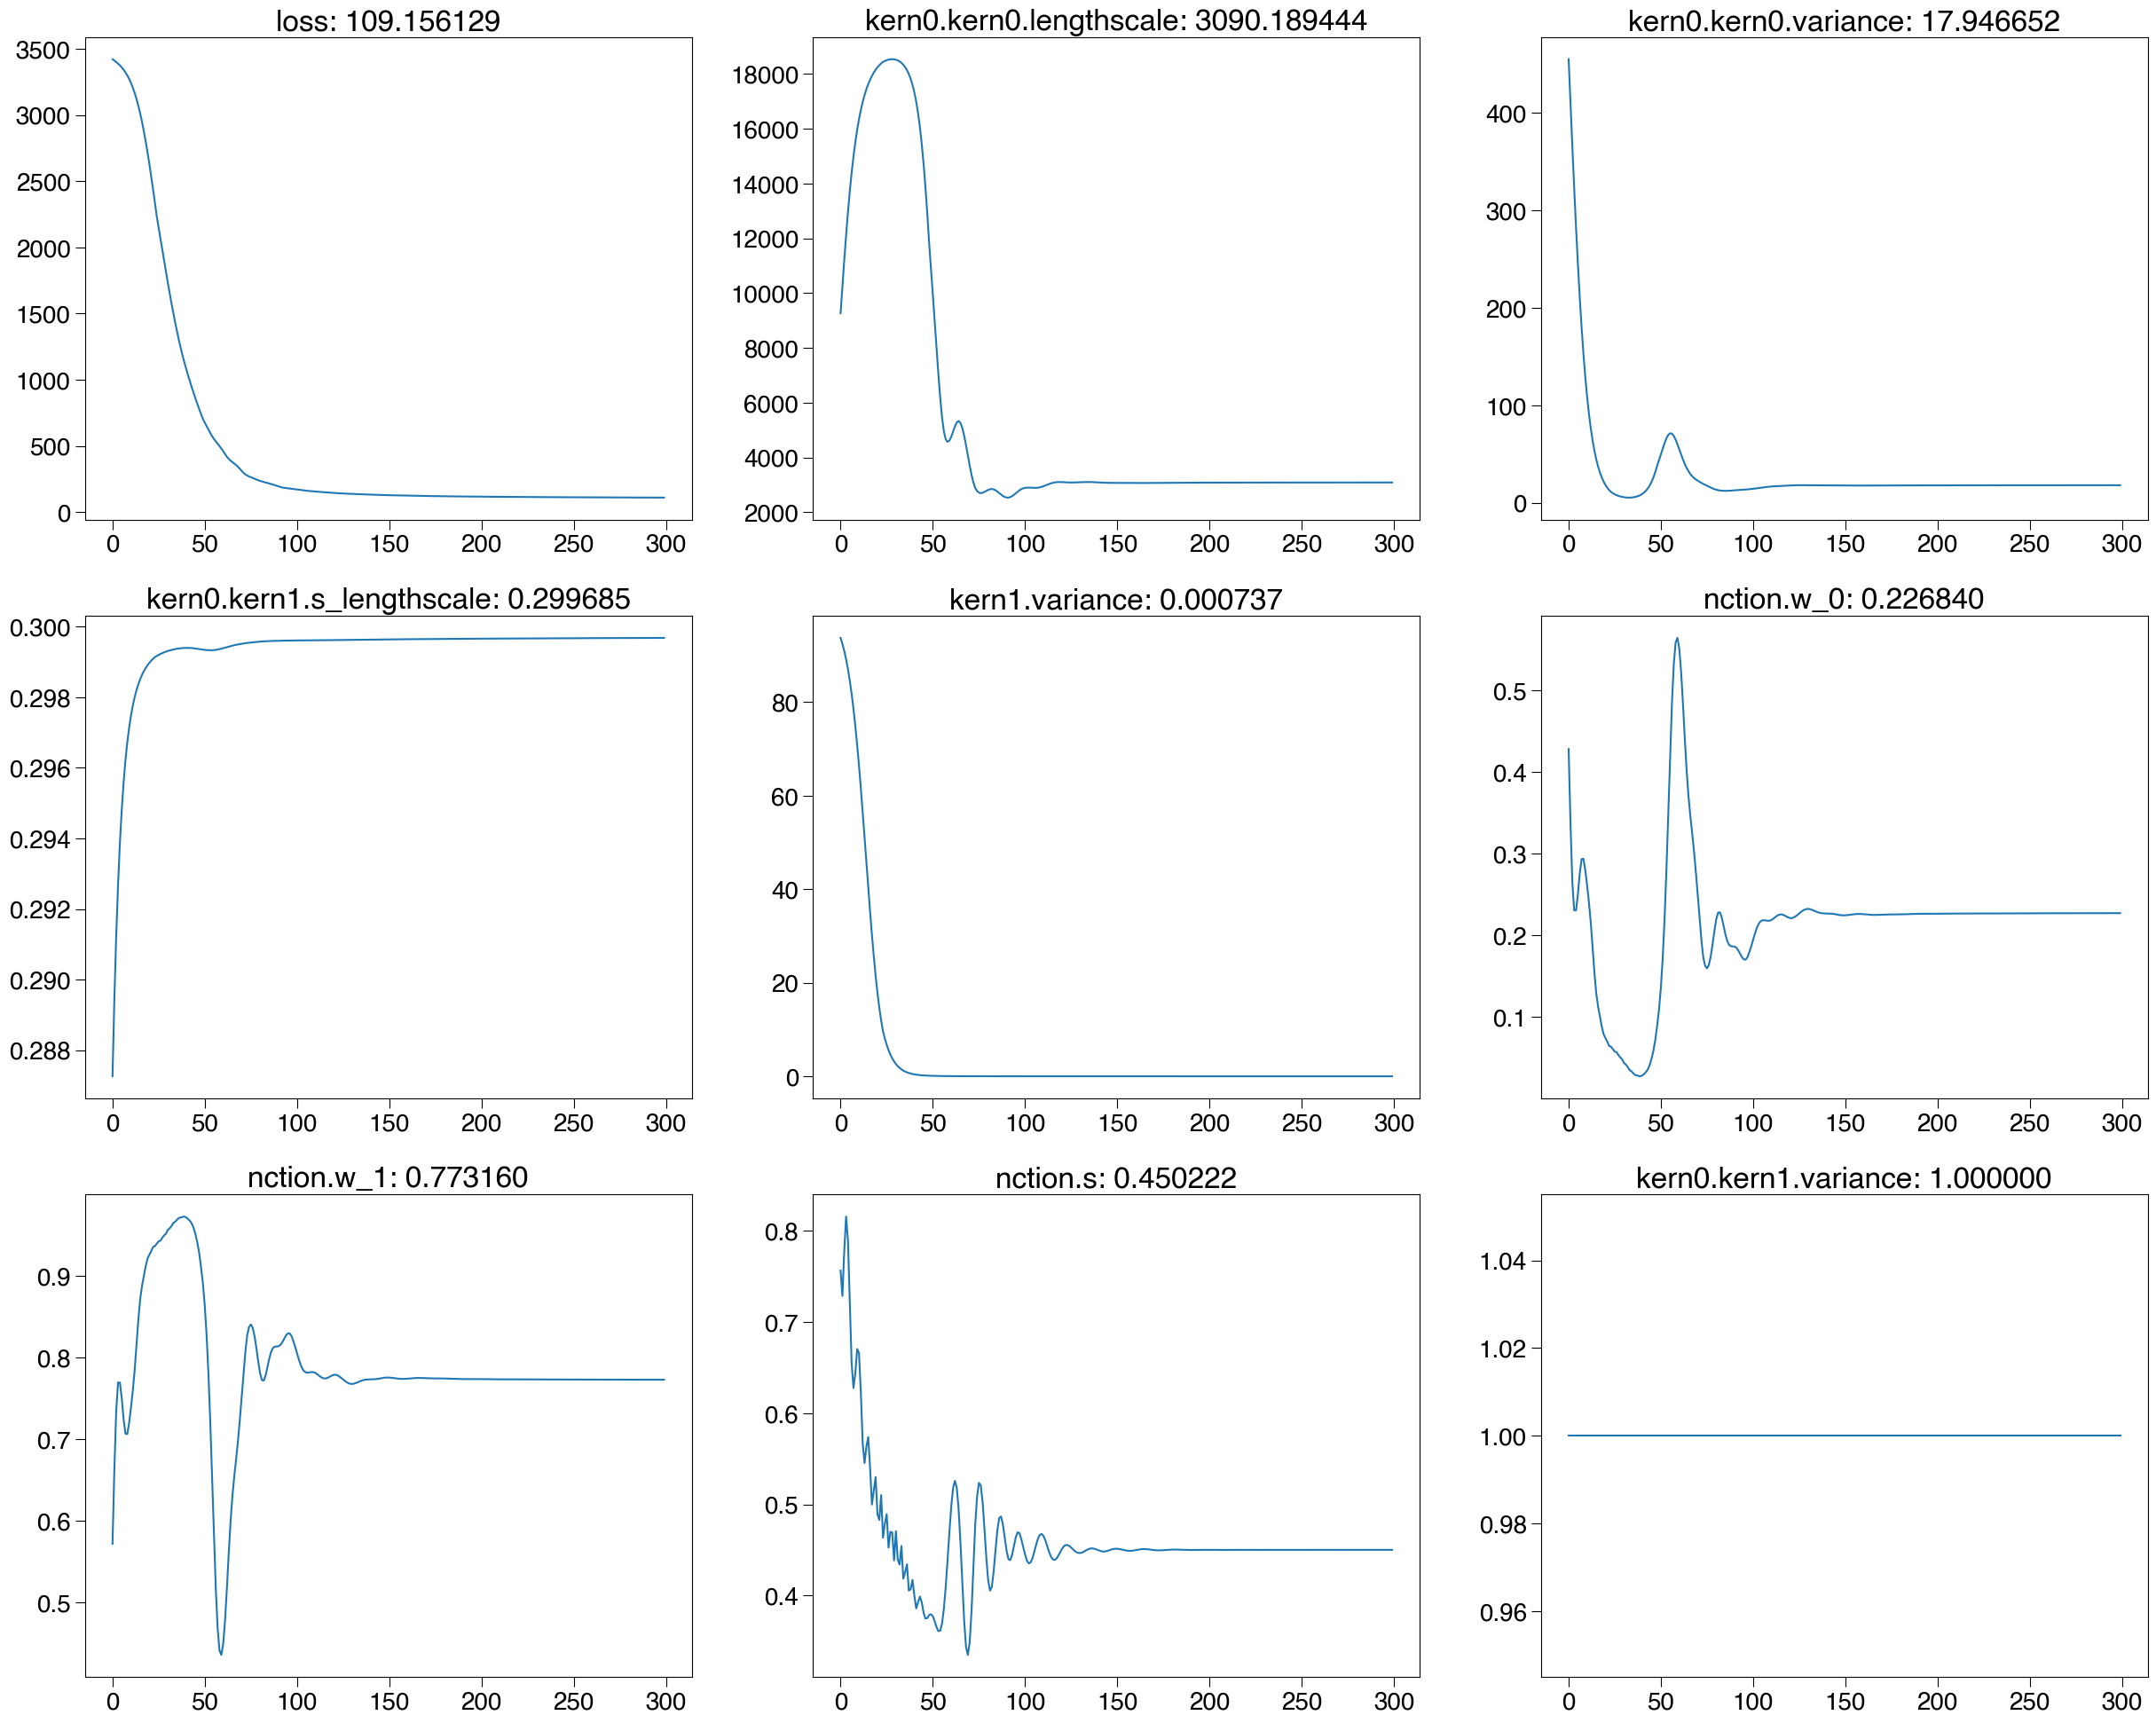

In [361]:
# from pyro.infer import MCMC, NUTS

st = time.time() 

pyro.clear_param_store()

#define locally non-linar spatio-temporal kernel
local_nl__temporal_kernel = PSTHM.kernels.Matern32(input_dim=1,geo=False)
local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(20000.)))
local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(30.**2)))
local_nl__spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.3)))
local_nl_kernel = PSTHM.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

#define whitenoise kernel
whitenoise_kernel = PSTHM.kernels.WhiteNoise(input_dim=1)
whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.01**2),torch.tensor(100.)))

#combine all kernels
combined_sp_kernel = PSTHM.kernels.Sum(local_nl_kernel,whitenoise_kernel)

#----define mean function
# the first number (2) here means there are 2 GIA models to interpolate
mean_fn = PSTHM.model.GIA_ensemble([gowan_interp,ice7g_interp])
mean_fn.set_prior('w',dist.Dirichlet(torch.ones(2)))
mean_fn.set_prior('s',dist.Normal(torch.tensor(1.0),torch.tensor(0.2)))

gpr_3 = PSTHM.model.GPRegression_V(X_new, y, combined_sp_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5,mean_function=mean_fn)

#Empirical bayes optimization, default iteration is 1000
gpr_3,track_list = PSTHM.opti.SVI_NI_optm(gpr_3,x_sigma=age_sigma,num_iteration=300,lr=0.2,decay_r = 0.8,step_size=25)
axes = PSTHM.plotting.plot_track_list(track_list)

#calulate log likelihood of the model prediction

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

print('local non-linear kernel lengthscale: {:3.3f}, s_lengthscale {:3.3f}, variance: {:3.3f}'.format(gpr_3.kernel.kern0.kern0.lengthscale,
                                                                                                      gpr_3.kernel.kern0.kern1.s_lengthscale,gpr_3.kernel.kern0.kern0.variance))
print('w_0: {:3.2f}, w_1: {:3.2f}'.format(*gpr_3.mean_function.w))
print('s: {:3.2f}'.format(gpr_3.mean_function.s))

You can see that, two GIA gains similar weights factors with a very low scaling parameter 0.5, indicating it srinks down the original GIA prediction by almost a half. Although tt does not have a physical meaning, it does show the optimization algorithsm is able to find the best GIA signal to fit the data with GP model. Let's see how it impact on local RSL prediction:

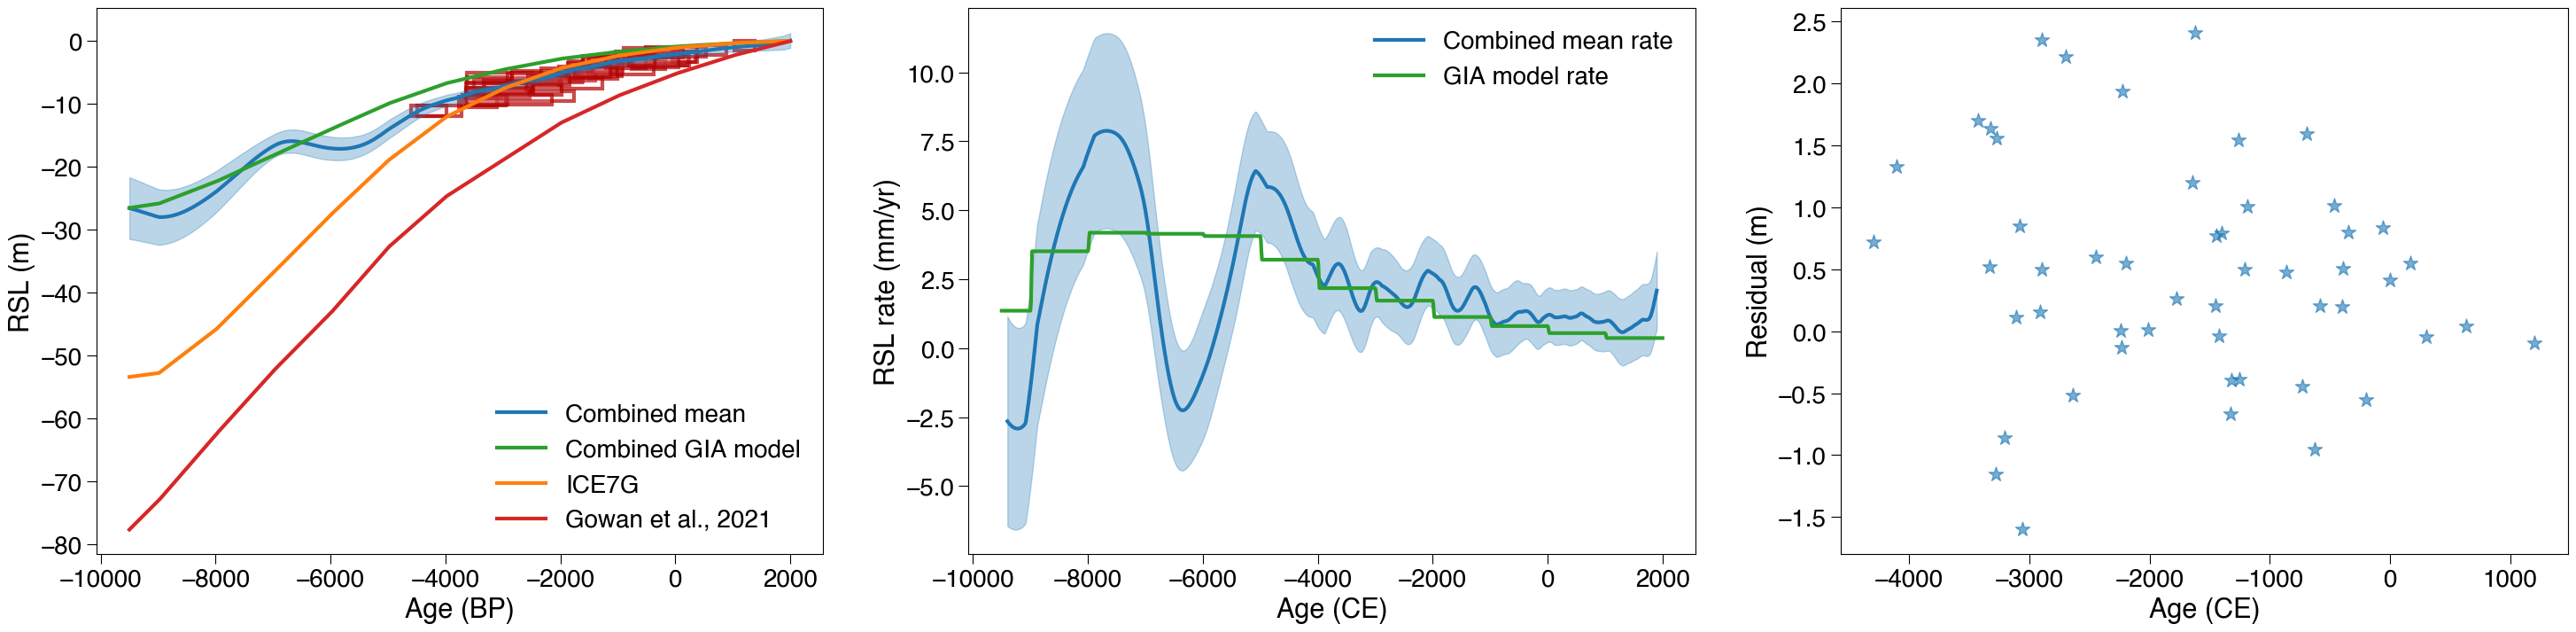

In [86]:
#generate prediction matrix
#Change the number here to visulize RSL at different sites!
#this range can be between 0-16
NJ_index = rsl_region==5
#------------------------------------------------------------

test_age =  np.arange(-9500,2010,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
pred_matrix[:,2]+=360
y_mean, y_var = gpr_3(pred_matrix.double(), full_cov=True)
y_std = y_var.diag().sqrt()
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(test_age,y_var.cpu().detach().numpy(),y_mean.cpu().detach().numpy())
mean_GIA = gpr_3.mean_function(pred_matrix)
GIA_model_rate = np.gradient(mean_GIA.detach().numpy(),test_age)

#plot the prediction
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plotting.plot_uncertainty_boxes(X[:,0][NJ_index],y[NJ_index], age_sigma[NJ_index]*2,y_sigma[NJ_index]*2,ax=ax)
plt.plot(test_age,y_mean.detach().numpy(),'C0',linewidth=3,label='Combined mean')
plt.fill_between(test_age,y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3)
plt.plot(test_age,mean_GIA.detach().numpy(),'C2',linewidth=3,label='Combined GIA model')
plt.plot(test_age,ice7g_interp(pred_matrix),'C1',linewidth=3,label='ICE7G')
plt.plot(test_age,gowan_interp(pred_matrix),'C3',linewidth=3,label='Gowan et al., 2021')

plt.legend()

plt.subplot(132)
plt.plot(rsl_time,rsl_rate*1000,'C0',linewidth=3,label='Combined mean rate')
plt.fill_between(rsl_time,(rsl_rate-2*rsl_rate_sd)*1000,(rsl_rate+2*rsl_rate_sd)*1000,color='C0',alpha=0.3)
plt.plot(test_age,GIA_model_rate*1000,'C2',linewidth=3,label='GIA model rate')
plt.legend()
plt.ylabel('RSL rate (mm/yr)')
plt.xlabel('Age (CE)')

plt.subplot(133)
f = interpolate.interp1d(test_age,y_mean.detach().numpy())
residual = f(X[:,0][NJ_index])-y[NJ_index].detach().numpy()
plt.scatter(X[:,0][NJ_index],residual,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (m)');


You can that, unlike using one GIA model above, here we optimize the GIA prediction along with GP, in this case, GIA model prediction fits much better with RSL data here. And we can now see the low scaling factor is due to both GIA model predicts much lower sea level than observation. And let's see how does it impact the spatial prediction.

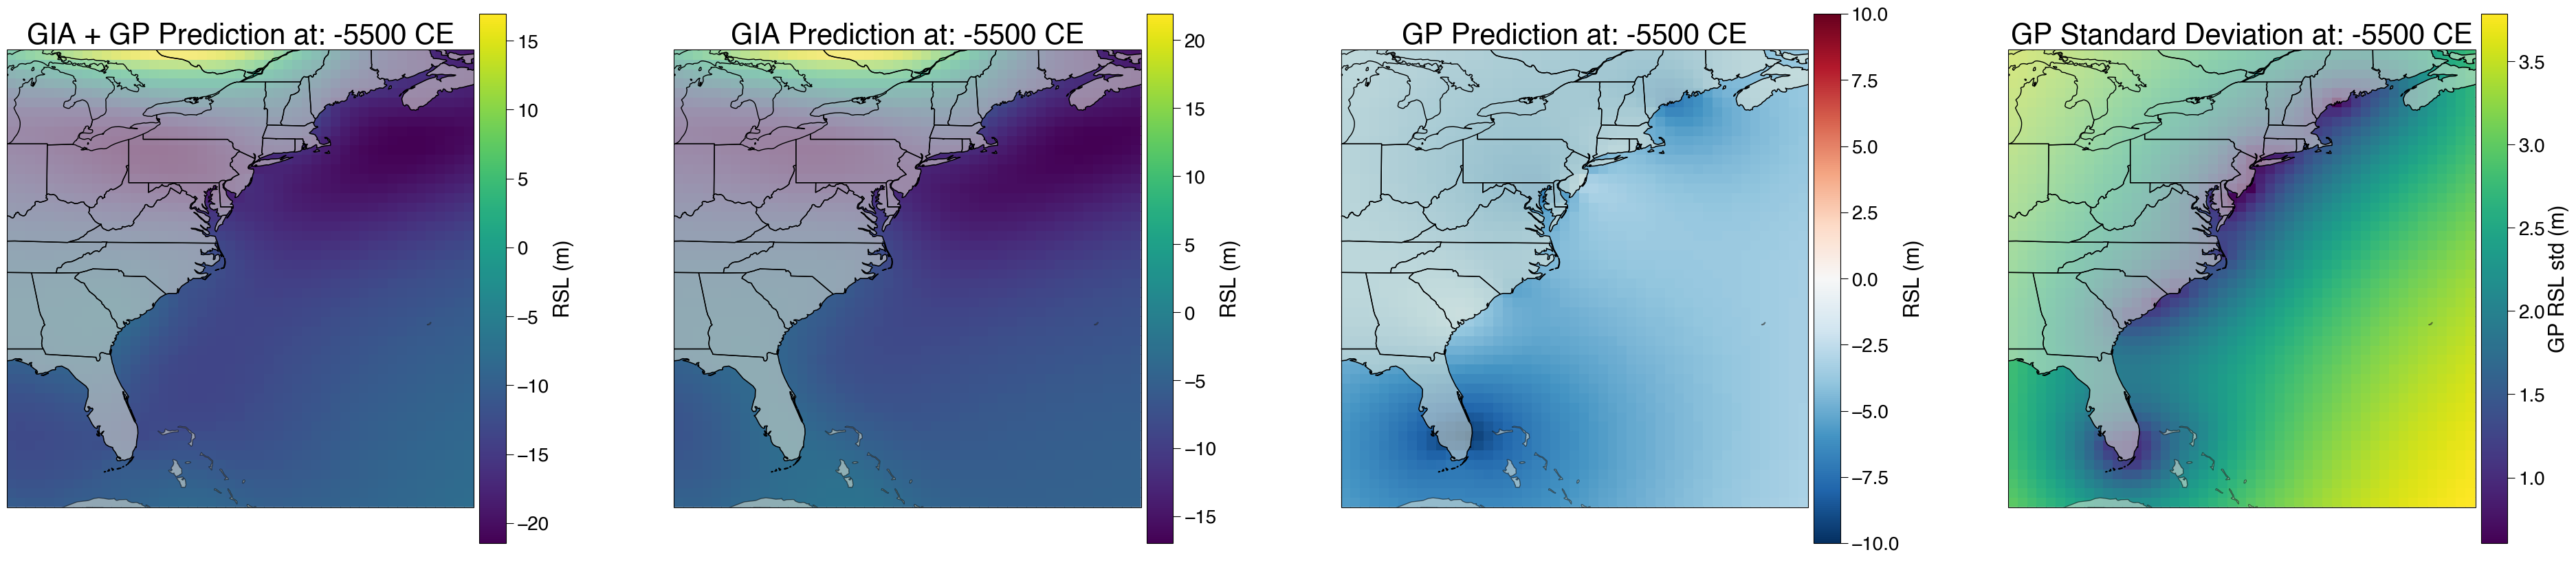

In [363]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-5,np.max(rsl_lon)+5,0.5)
#Change the number here to visulize RSL at different time!!
time_mat = np.array([-5500]) 
#---------------------------------------------------------------------
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
pred_matrix[:,2]+=360
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
y_mean, y_var = gpr_3(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()

#------------plot -----------------
plt.figure(figsize=(48,10))
ax2 = plt.subplot(141,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_mean.detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='viridis',zorder=-1)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA + GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(142,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,gpr_3.mean_function(pred_matrix).detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='viridis',zorder=-1)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(143,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,(y_mean-gpr_3.mean_function(pred_matrix)).detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=10,vmin=-10,zorder=-1)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(144,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_std.detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='viridis',zorder=-1)
cbar = fig.colorbar(cax, ax=ax2, orientation='vertical', pad=0.01)
cbar.set_label('GP RSL std (m)')
ax2.set_title('GP Standard Deviation at: {:} CE'.format(time_mat[0]),fontsize=30);

You can see that, because GIA models (i.e., GP mean function) fits better to the observations, GP kernel predictions are relatively smaller compared with the resulting using one GIA model above. Therefore, we can now optimize the GIA model performance and fill out the rest with kernel predictions, which is good because GIA model represent a well-known physics knowledge of sea-level change. 

Importantly, you can use any number of physical model as you wish (not restricted to 2), so you can also calibrate physical model parameter along with the GP framework!



### 4. Build empirical covariance function through physical model ensembles

Let's switch our mind a bit. Instead of using physical model as a mean function in GP, we can actually use physical model to build an empirical covariance function through sampling covariance. To do that, let's include an additional GIA model, which is based on ANU ice model with 71 km lithosphere 1/10 x $^{21}$ Pa s upper/lower mantle viscosity.


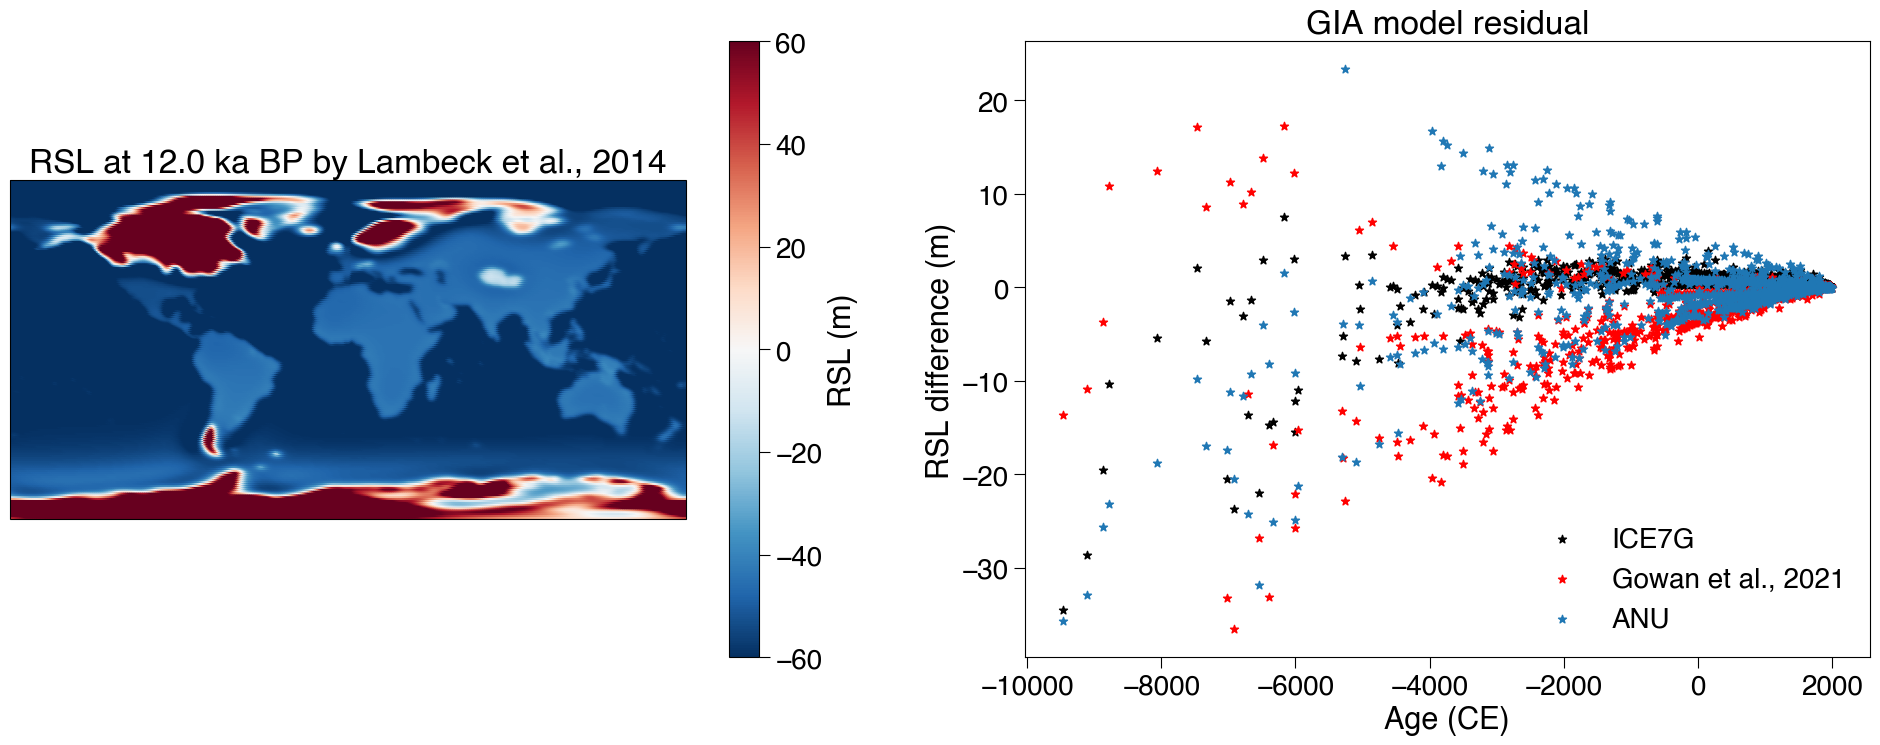

In [10]:
ANU_time = np.array([0, 0.1 ,  1.  ,  2.3 ,  2.83,  3.66,  4.75,  6.  ,  6.8 ,  7.35,
        7.9 ,  8.45,  9.65, 10.27, 10.91, 11.54, 12.  , 13.  ])
ANU_time_CE = -(ANU_time*1000-1950)+67
ANU_rsl = np.load('ANU.npy')[:,::-1]

ANU_interp = rgi((ANU_time_CE,lat,lon), ANU_rsl)
ANU_pred = ANU_interp(X_new)


time_index = 16
fig = plt.figure(figsize=(24,8))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())

im = ax2.scatter(lon_matrix_GIA,lat_matrix_GIA,c = ANU_rsl[time_index],cmap='RdBu_r',zorder=0,vmax = 60,vmin=-60)
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('RSL at {:} ka BP by Lambeck et al., 2014'.format(ANU_time[time_index]))


plt.subplot(122)
plt.scatter(X_new[:,0],ice7g_pred-y.cpu().detach().numpy(),c='k',marker='*',label='ICE7G')
plt.scatter(X_new[:,0],gowan_pred-y.cpu().detach().numpy(),c='r',marker='*',label='Gowan et al., 2021')
plt.scatter(X_new[:,0],ANU_pred-y.cpu().detach().numpy(),c='C0',marker='*',label='ANU')
plt.xlabel('Age (CE)')
plt.ylabel('RSL difference (m)')
plt.title('GIA model residual')
plt.legend();

Ok! Now, let's try to estimate covariance based on sampling covariance. To mimic the physical model variability due to uncertain ice/earth model parameters, here I include some synthetic GIA model result by enlarging or shrinking the original modeling result by 1.5 or 2. We can then calculate empirical covariance function assuming equal weighting, or we can calculate weighted covariance based on each model godness of fit to the data. Let's try both here:

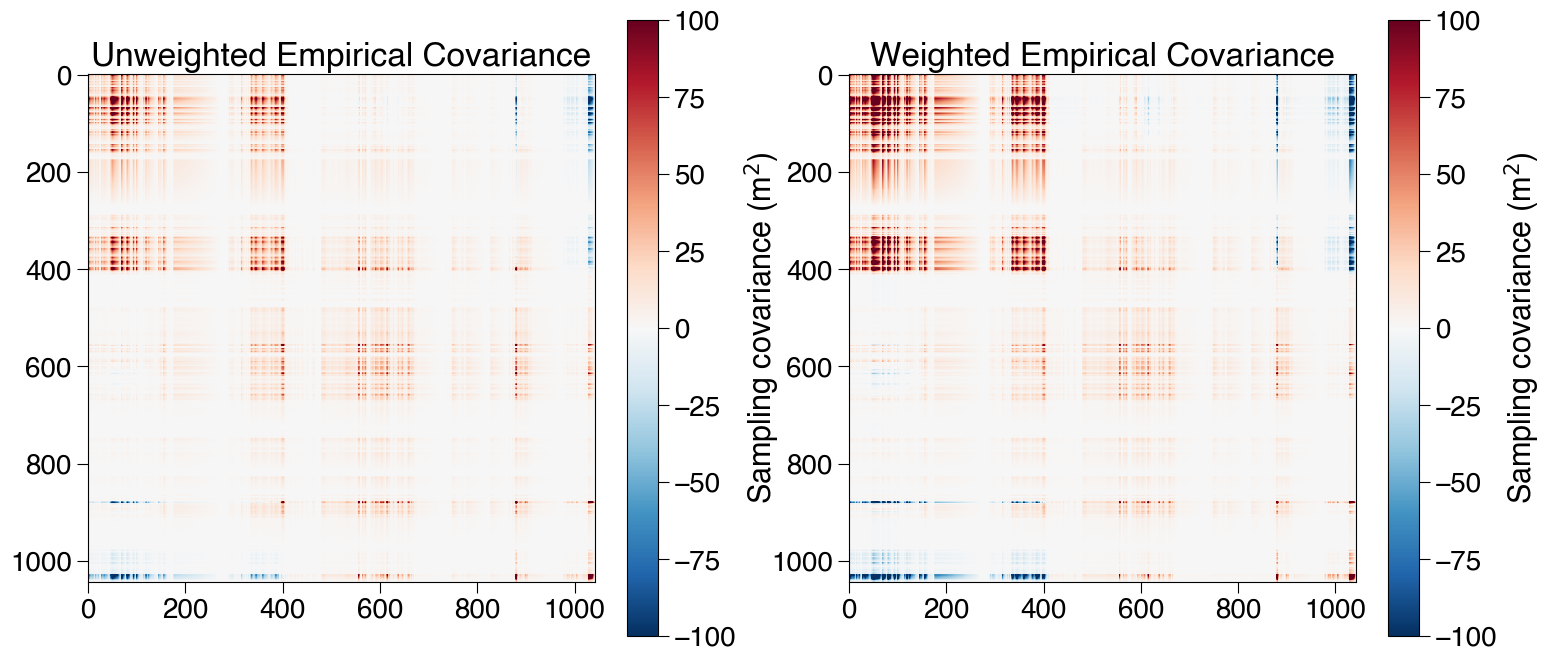

In [11]:
ANU_interp_2 = rgi((ANU_time_CE,lat,lon), ANU_rsl*1.5)
ANU_interp_3 = rgi((ANU_time_CE,lat,lon), ANU_rsl/1.5)
ANU_pred_2 = ANU_interp_2(X_new)
ANU_pred_3 = ANU_interp_3(X_new)
ice7g_interp_2 = rgi((time_CE[::-1],lat,lon), ice7g_rsl[::-1]*1.5)
ice7g_interp_3 = rgi((time_CE[::-1],lat,lon), ice7g_rsl[::-1]/1.5)
ice7g_pred_2 = ice7g_interp_2(X_new)
ice7g_pred_3 = ice7g_interp_3(X_new)
gowan_interp_2 = rgi((time_CE[::-1],lat,lon), gowan_rsl[::-1]*1.5)
gowan_interp_3 = rgi((time_CE[::-1],lat,lon), gowan_rsl[::-1]/1.5)
gowan_pred_2 = gowan_interp_2(X_new)
gowan_pred_3 = gowan_interp_3(X_new)

all_rsl = np.zeros([9,len(X_new)])
all_rsl[0] = ice7g_pred
all_rsl[1] = gowan_pred
all_rsl[2] =ANU_pred
all_rsl[3] = ice7g_pred_2
all_rsl[4] = gowan_pred_2
all_rsl[5] = ANU_pred_2
all_rsl[6] = ice7g_pred_3
all_rsl[7] = gowan_pred_3
all_rsl[8] = ANU_pred_3

emp_covar =   np.cov(all_rsl.T)

#calculate goodness of fit based on mean sqaured difference
ice7g_weight = np.mean((ice7g_pred - y.cpu().detach().numpy())**2)
gowan_weight = np.mean((gowan_pred - y.cpu().detach().numpy())**2)
ANU_weight = np.mean((ANU_pred - y.cpu().detach().numpy())**2)
ice7g_2_weight = np.mean((ice7g_pred_2 - y.cpu().detach().numpy())**2)
gowan_2_weight = np.mean((gowan_pred_2 - y.cpu().detach().numpy())**2)
ANU_2_weight = np.mean((ANU_pred_2 - y.cpu().detach().numpy())**2)
ice7g_3_weight = np.mean((ice7g_pred_3 - y.cpu().detach().numpy())**2)
gowan_3_weight = np.mean((gowan_pred_3 - y.cpu().detach().numpy())**2)
ANU_3_weight = np.mean((ANU_pred_3 - y.cpu().detach().numpy())**2)

weights = np.array([ice7g_weight,gowan_weight,ANU_weight,ice7g_2_weight,gowan_2_weight,ANU_2_weight,ice7g_3_weight,gowan_3_weight,ANU_3_weight])
weights = weights/np.sum(weights)
weigthed_emp_covar = np.cov(all_rsl.T,aweights=weights)

plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(emp_covar,cmap='RdBu_r',vmax=100,vmin=-100)
plt.colorbar(label='Sampling covariance (m$^2$)')
plt.title('Unweighted Empirical Covariance')

plt.subplot(122)
plt.imshow(weigthed_emp_covar,cmap='RdBu_r',vmax=100,vmin=-100)
plt.colorbar(label='Sampling covariance (m$^2$)')
plt.title('Weighted Empirical Covariance');

You can start to see some non-stationary features in this covariance function. Let's combine this weighted empirical kernel with a local non-linear kernel as we used before. You can use the Emprical kernel function in PaleoSTeHM. To stabilize the estimate and reduce variability related to finite sample size, we applied a temporal Gaussian taper function to each empirical kernel function $K_{emp}$, so it becomes:
$$
K_{emp}(X,X') = K_{emp}(X,X') \times exp(-|t-t'|^2/\tau^2)
$$
where $X$ indicates spatiotemporal information, $|t-t'|^2$ is squared temporal distance matrix, $\tau$ is parameter for temporal tapering, if you do not set $\tau$, there is no tapering. Here we set 2000 year taper. And we use an empirical kernel with a whitenoise kernel to discribe sea level change.

In [13]:

st = time.time() 

pyro.clear_param_store()

#define locally non-linar spatio-temporal kernel
model_ensemble = [ice7g_interp,gowan_interp,ANU_interp,ice7g_interp_2,gowan_interp_2,ANU_interp_2,ice7g_interp_3,gowan_interp_3,ANU_interp_3]
empirical_kernel = PSTHM.kernels.Empirical(input_dim=1,model_ensemble=model_ensemble,weights=weights,tau=2000)

#define locally non-linar spatio-temporal kernel
white_noise_kernel = PSTHM.kernels.WhiteNoise(input_dim =1)
white_noise_kernel.set_prior('variance',dist.Uniform(1e-3,10.))
combined_sp_kernel = PSTHM.kernels.Sum(empirical_kernel,white_noise_kernel)

gpr_4 = PSTHM.model.GPRegression_V(X_new, y, combined_sp_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)
gpr_4,track_list = PSTHM.opti.SVI_NI_optm(gpr_4,age_sigma,num_iteration=100,lr=0.2)
# PSTHM.plotting.plot_track_list(track_list)
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

  0%|          | 0/100 [00:00<?, ?it/s]

Execution time: 12.396 s


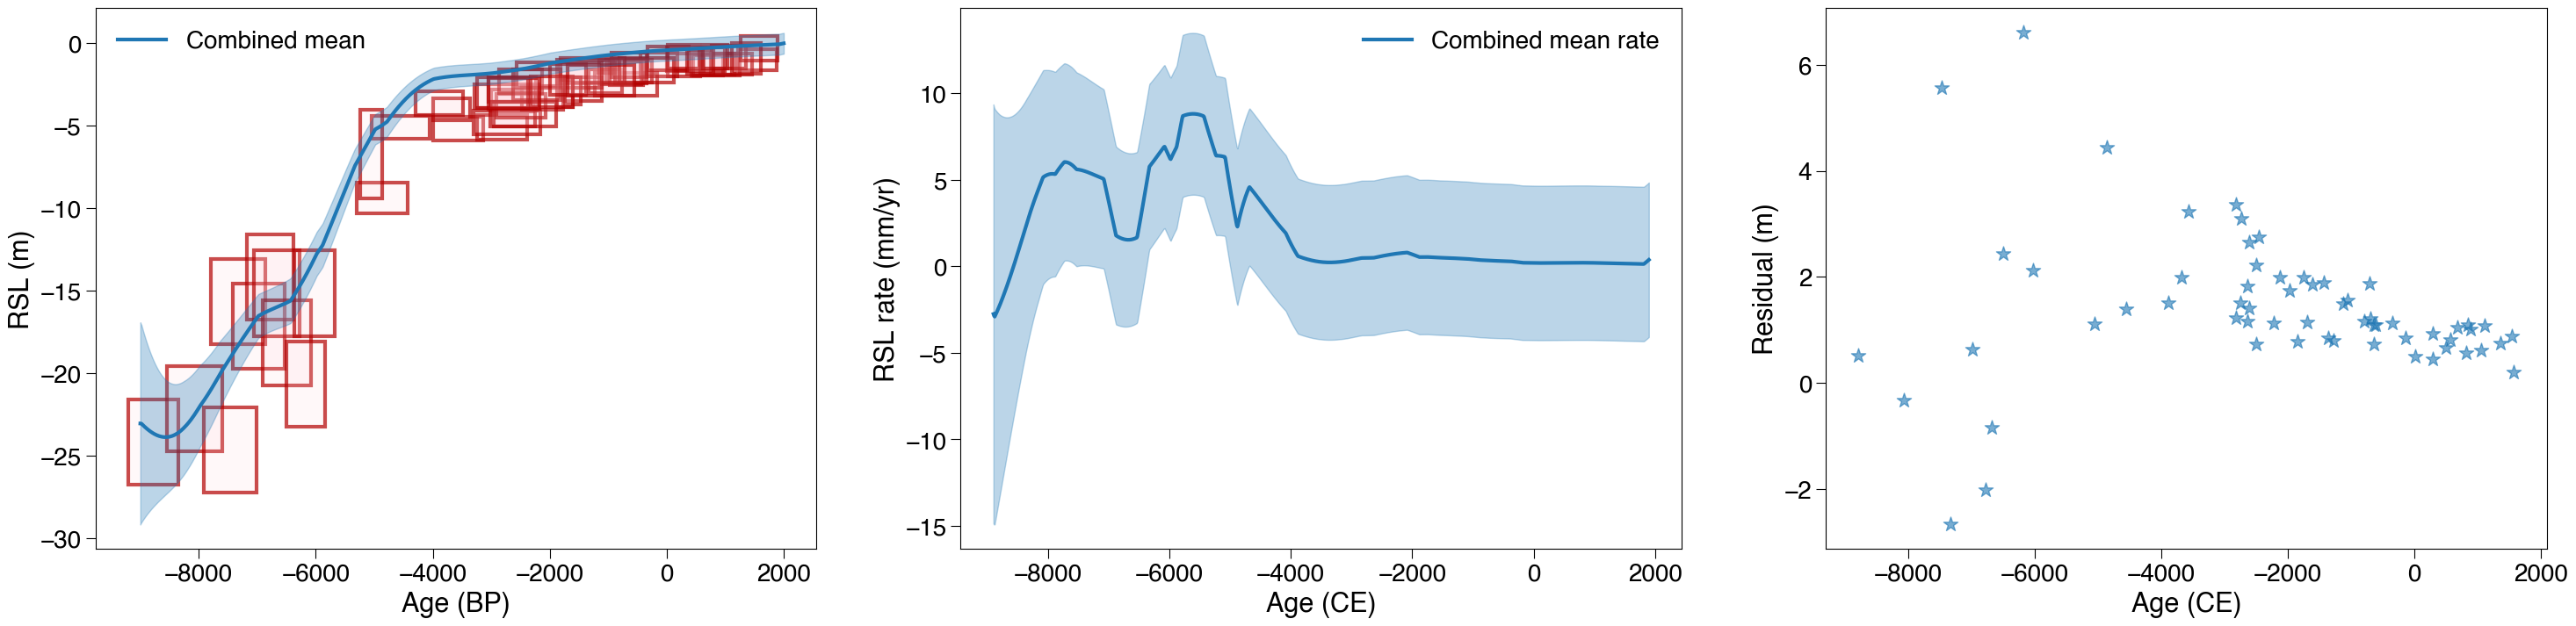

In [14]:
#generate prediction matrix
#Change the number here to visulize RSL at different sites!
#this range can be between1-16
NJ_index = rsl_region==15
#------------------------------------------------------------
test_age =  np.arange(-9000,2010,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
pred_matrix[:,2]+=360
y_mean_3, y_var_3 = gpr_4(pred_matrix.double(), full_cov=True)
y_std_3 = y_var_3.diag().sqrt()
rsl_time_3,rsl_rate_3,rsl_rate_sd_3 = PSTHM.cal_rate_var(test_age,y_var_3.cpu().detach().numpy(),y_mean_3.cpu().detach().numpy())


#plot the prediction
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plotting.plot_uncertainty_boxes(X[:,0][NJ_index],y[NJ_index], age_sigma[NJ_index]*2,y_sigma[NJ_index]*2,ax=ax)
plt.plot(test_age,y_mean_3.detach().numpy(),'C0',linewidth=3,label='Combined mean')
plt.fill_between(test_age,y_mean_3.detach().numpy()-2*y_std_3.detach().numpy(),y_mean_3.detach().numpy()+2*y_std_3.detach().numpy(),color='C0',alpha=0.3)

plt.legend()

plt.subplot(132)
plt.plot(rsl_time_3,rsl_rate_3*1000,'C0',linewidth=3,label='Combined mean rate')
plt.fill_between(rsl_time_3,(rsl_rate_3-2*rsl_rate_sd_3)*1000,(rsl_rate_3+2*rsl_rate_sd_3)*1000,color='C0',alpha=0.3)
plt.legend()
plt.ylabel('RSL rate (mm/yr)')
plt.xlabel('Age (CE)')

plt.subplot(133)
f = interpolate.interp1d(test_age,y_mean_3.detach().numpy())
residual = f(X[:,0][NJ_index])-y[NJ_index].detach().numpy()
plt.scatter(X[:,0][NJ_index],residual,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (m)');



In [15]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-5,np.max(rsl_lon)+5,0.5)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
test_time = -5500.
pred_matrix = PSTHM.post.gen_pred_matrix([test_time],lat_matrix,lon_matrix)
pred_matrix[:,2]+=360

#-----------------define the kernel to decompose-----------------
y_mean_spa_3, y_var_spa_3 = gpr_4(pred_matrix.double(), full_cov=True)
y_std_spa_3 = y_var_spa_3.diag().sqrt()


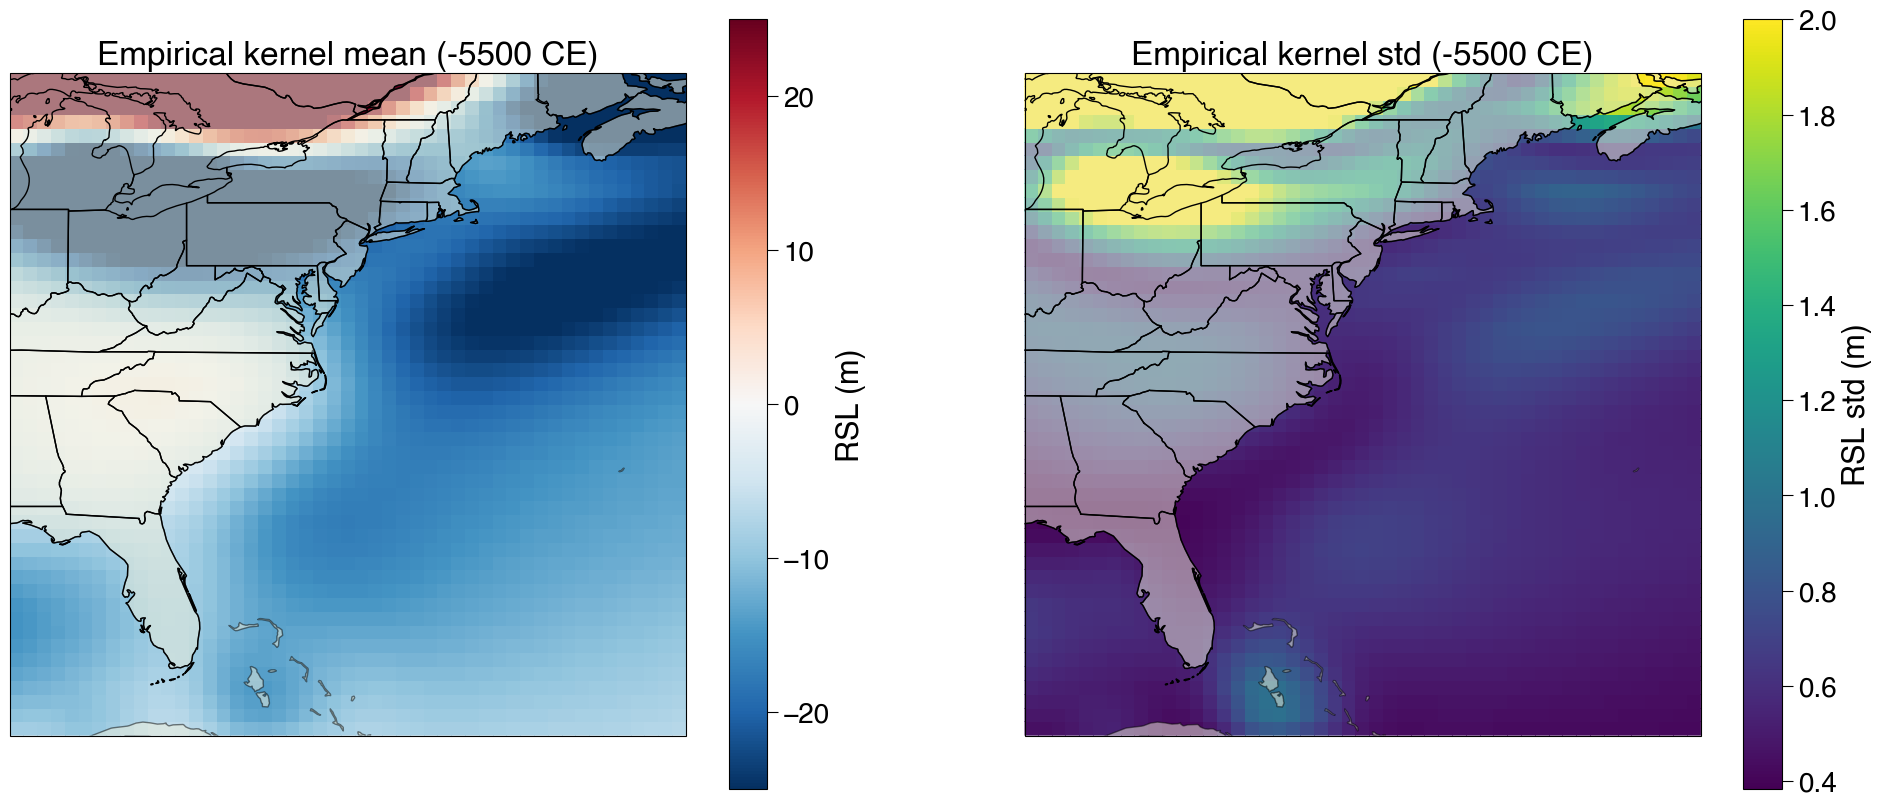

In [16]:
plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(y_mean_spa_3).detach().numpy().reshape(lat_mat.shape),zorder=-1,vmax=25,vmin=-25,cmap='RdBu_r')
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Empirical kernel mean ({:} CE)'.format(int(test_time)))

ax2 = plt.subplot(122,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(y_std_spa_3).detach().numpy().reshape(lat_mat.shape),zorder=-1,vmax=2)

plt.colorbar(im,ax=ax2,label='RSL std (m)')
plt.title('Empirical kernel std ({:} CE)'.format(int(test_time)));


You can now see that because we are using a physical model, the uncertainty 

### 6. Probabilistically calibrating physical model ensemble

You can also only define a GP kernel with a whitenoise kernel but sampling the weighting parameter for different physical models, so the output is a probablity distribution of different physical parameters.

In [17]:
import time
st = time.time() 

pyro.clear_param_store()


#define whitenoise kernel
whitenoise_kernel = PSTHM.kernels.WhiteNoise(input_dim=1)
whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.01**2),torch.tensor(100.)))

#combine all kernels
#----define mean function
# the first number (2) here means there are 2 GIA models to interpolate
mean_fn = PSTHM.model.GIA_ensemble(model_ensemble)
mean_fn.set_prior('w',dist.Dirichlet(torch.ones(len(model_ensemble))))
mean_fn.autoguide("w",dist.Normal) 
mean_fn.set_prior('s',dist.Normal(torch.tensor(1.0),torch.tensor(1e-5)))

gpr_5 = PSTHM.model.GPRegression_V(X_new, y,kernel = whitenoise_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5,mean_function=mean_fn)
gpr_5,track_list = PSTHM.opti.SVI_optm(gpr_5,num_iteration=300,lr=0.2)
# PSTHM.plotting.plot_track_list(track_list)

#you can use MCMC here
# gpr = PSTHM.model.GPRegression_V(X_new, y,kernel = whitenoise_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5,mean_function=mean_fn)
# mcmc = PSTHM.opti.NUTS_mcmc(gpr,num_samples=2000,warmup_steps=200)


  0%|          | 0/300 [00:00<?, ?it/s]

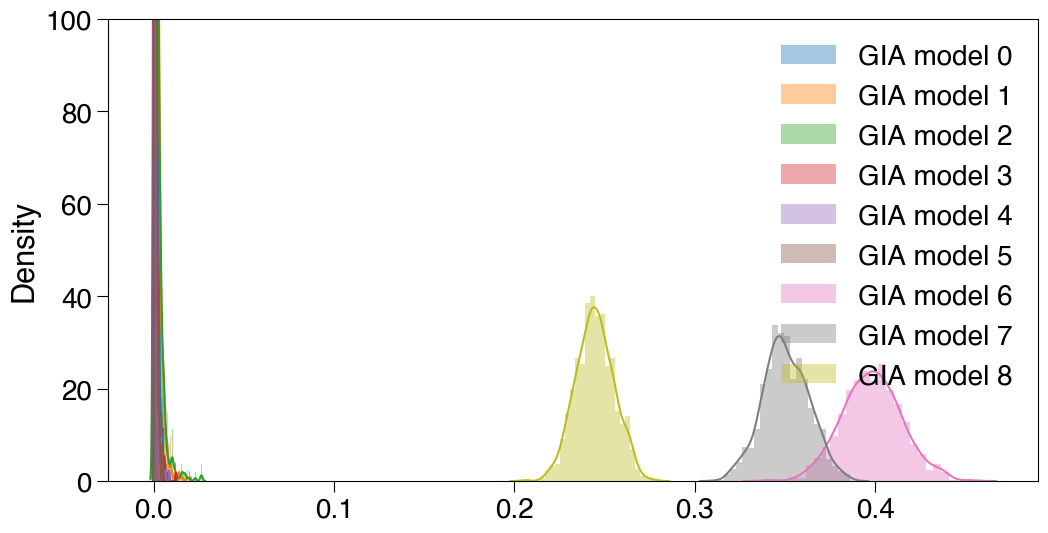

In [18]:
import seaborn as sns
testing_num = 1000
post_w = np.zeros([testing_num,len(model_ensemble)])
for i in range(testing_num):
    
    post_w[i] = mean_fn.w
for i in range(len(model_ensemble)):
    sns.distplot(post_w[:,i],label='GIA model '+str(i))
plt.legend(loc=1)
plt.ylim(0,100);

In [56]:
#generate prediction matrix
#Change the number here to visulize RSL at different sites!
#this range can be between1-16
NJ_index = rsl_region==15
#------------------------------------------------------------
test_age =  np.arange(-9000,2010,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[NJ_index]),np.mean(rsl_lon[NJ_index]))
pred_matrix[:,2]+=360

prior_pred = np.zeros([len(model_ensemble),len(test_age)])
for i in range(len(model_ensemble)):
    prior_pred[i] = model_ensemble[i](pred_matrix)
ensemble_pred = np.zeros([testing_num*10,len(test_age)])

for i in range(testing_num):
    test_prob = post_w[i]
    # ensemble_pred[i*10:(i+1)*10] = np.average(prior_pred,axis=0,weights=test_prob)
    random_index = np.random.choice(a=9, p=test_prob,size=10)
    ensemble_pred[i*10:(i+1)*10] = prior_pred[random_index]
    
mean_pred = np.mean(ensemble_pred,axis=0)
std_pred = np.std(ensemble_pred,axis=0)
rate_pred = np.gradient(ensemble_pred,test_age,axis=1)
mean_rate_pred = np.mean(rate_pred,axis=0)
std_rate_pred = np.std(rate_pred,axis=0)

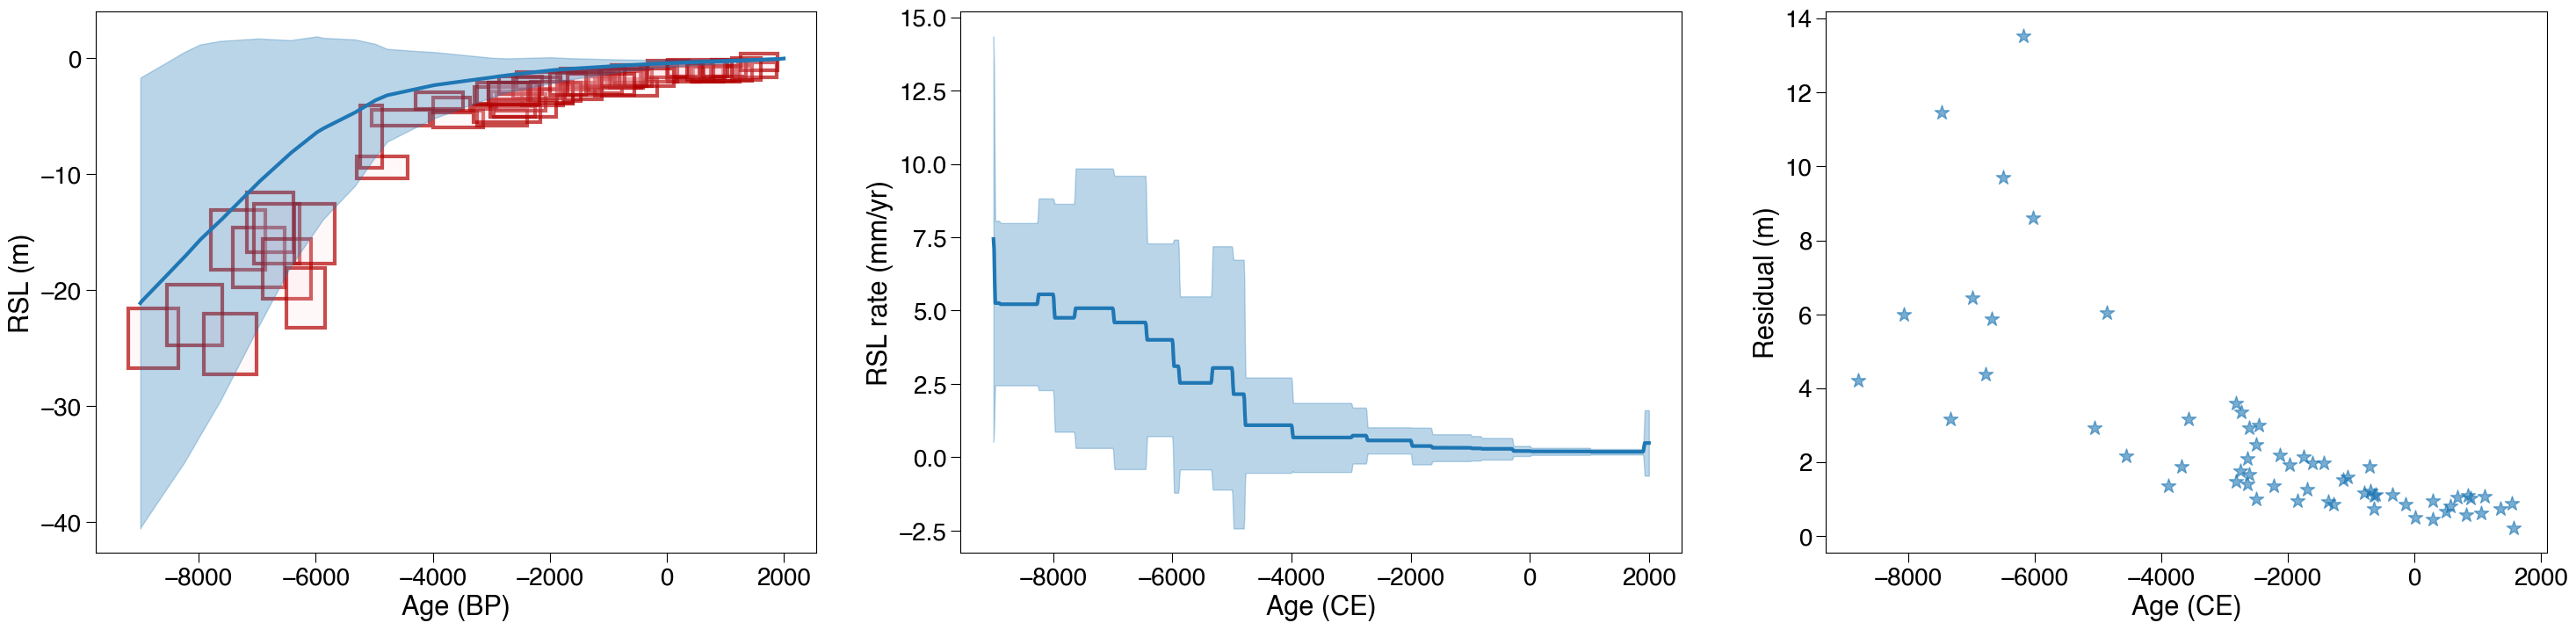

In [57]:


#plot the prediction
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plotting.plot_uncertainty_boxes(X[:,0][NJ_index],y[NJ_index], age_sigma[NJ_index]*2,y_sigma[NJ_index]*2,ax=ax)
plt.plot(test_age,mean_pred,'C0',linewidth=3)
plt.fill_between(test_age,mean_pred-2*std_pred,mean_pred+2*std_pred,color='C0',alpha=0.3)

plt.subplot(132)
plt.plot(test_age,mean_rate_pred*1000,'C0',linewidth=3)
plt.fill_between(test_age,(mean_rate_pred-2*std_rate_pred)*1000,(mean_rate_pred+2*std_rate_pred)*1000,color='C0',alpha=0.3)

plt.ylabel('RSL rate (mm/yr)')
plt.xlabel('Age (CE)')
plt.subplot(133)
f = interpolate.interp1d(test_age,mean_pred)
residual = f(X[:,0][NJ_index])-y[NJ_index].detach().numpy()
plt.scatter(X[:,0][NJ_index],residual,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')
plt.ylabel('Residual (m)');



In [58]:
lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-5,np.max(rsl_lon)+5,0.5)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
test_time = -5500.
pred_matrix = PSTHM.post.gen_pred_matrix([test_time],lat_matrix,lon_matrix)
pred_matrix[:,2]+=360

prior_pred = np.zeros([len(model_ensemble),len(pred_matrix)])
for i in range(len(model_ensemble)):
    prior_pred[i] = model_ensemble[i](pred_matrix)
ensemble_pred = np.zeros([testing_num*10,len(pred_matrix)])

for i in range(testing_num):
    test_prob = post_w[i]
    # ensemble_pred[i*10:(i+1)*10] = np.average(prior_pred,axis=0,weights=test_prob)
    random_index = np.random.choice(a=9, p=test_prob,size=10)
    ensemble_pred[i*10:(i+1)*10] = prior_pred[random_index]
mean_pred_spa = np.mean(ensemble_pred,axis=0)
std_pred_spa = np.std(ensemble_pred,axis=0)


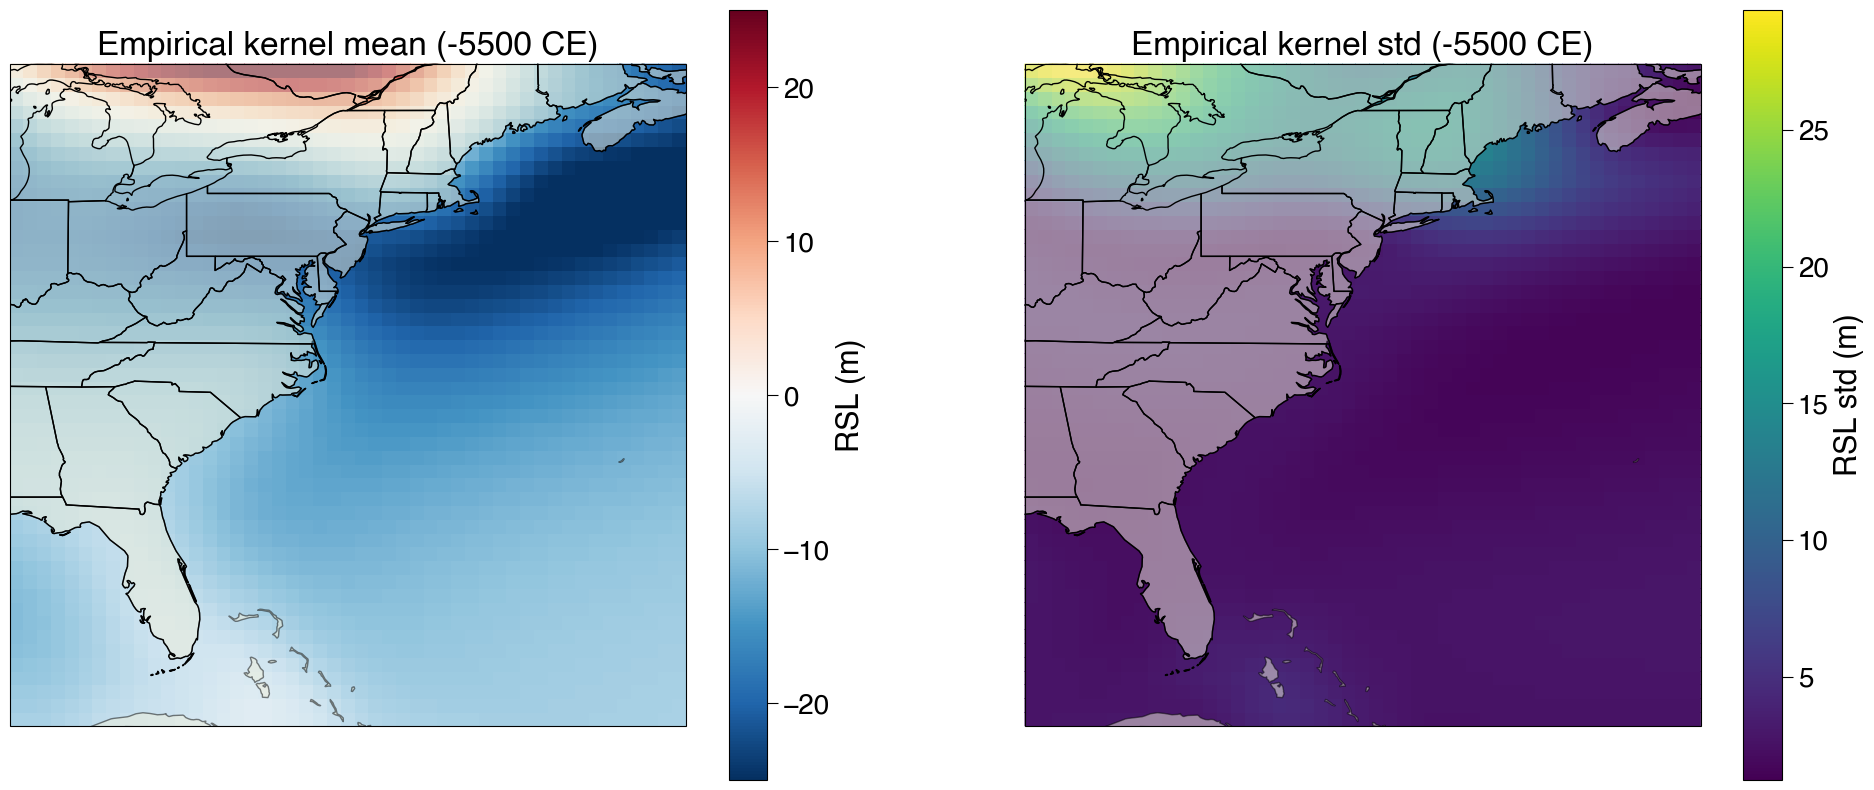

In [59]:
plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(mean_pred_spa).reshape(lat_mat.shape),zorder=-1,vmax=25,vmin=-25,cmap='RdBu_r')
plt.colorbar(im,ax=ax2,label='RSL (m)')
plt.title('Empirical kernel mean ({:} CE)'.format(int(test_time)))

ax2 = plt.subplot(122,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(std_pred_spa).reshape(lat_mat.shape),zorder=-1)

plt.colorbar(im,ax=ax2,label='RSL std (m)')
plt.title('Empirical kernel std ({:} CE)'.format(int(test_time)));


### Comparison 

In [523]:
np.sum(site_index)

61

In [519]:
site_index = rsl_region==15

test_age =  np.arange(-9000,2010,10)
pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(rsl_lat[site_index]),np.mean(rsl_lon[site_index]))
pred_matrix[:,2]+=360

lat_matrix = np.arange(np.min(rsl_lat)-2,np.max(rsl_lat)+2,0.5)
lon_matrix = np.arange(np.min(rsl_lon)-5,np.max(rsl_lon)+5,0.5)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
test_time = -5500.
pred_matrix_2 = PSTHM.post.gen_pred_matrix([test_time],lat_matrix,lon_matrix)
pred_matrix_2[:,2]+=360

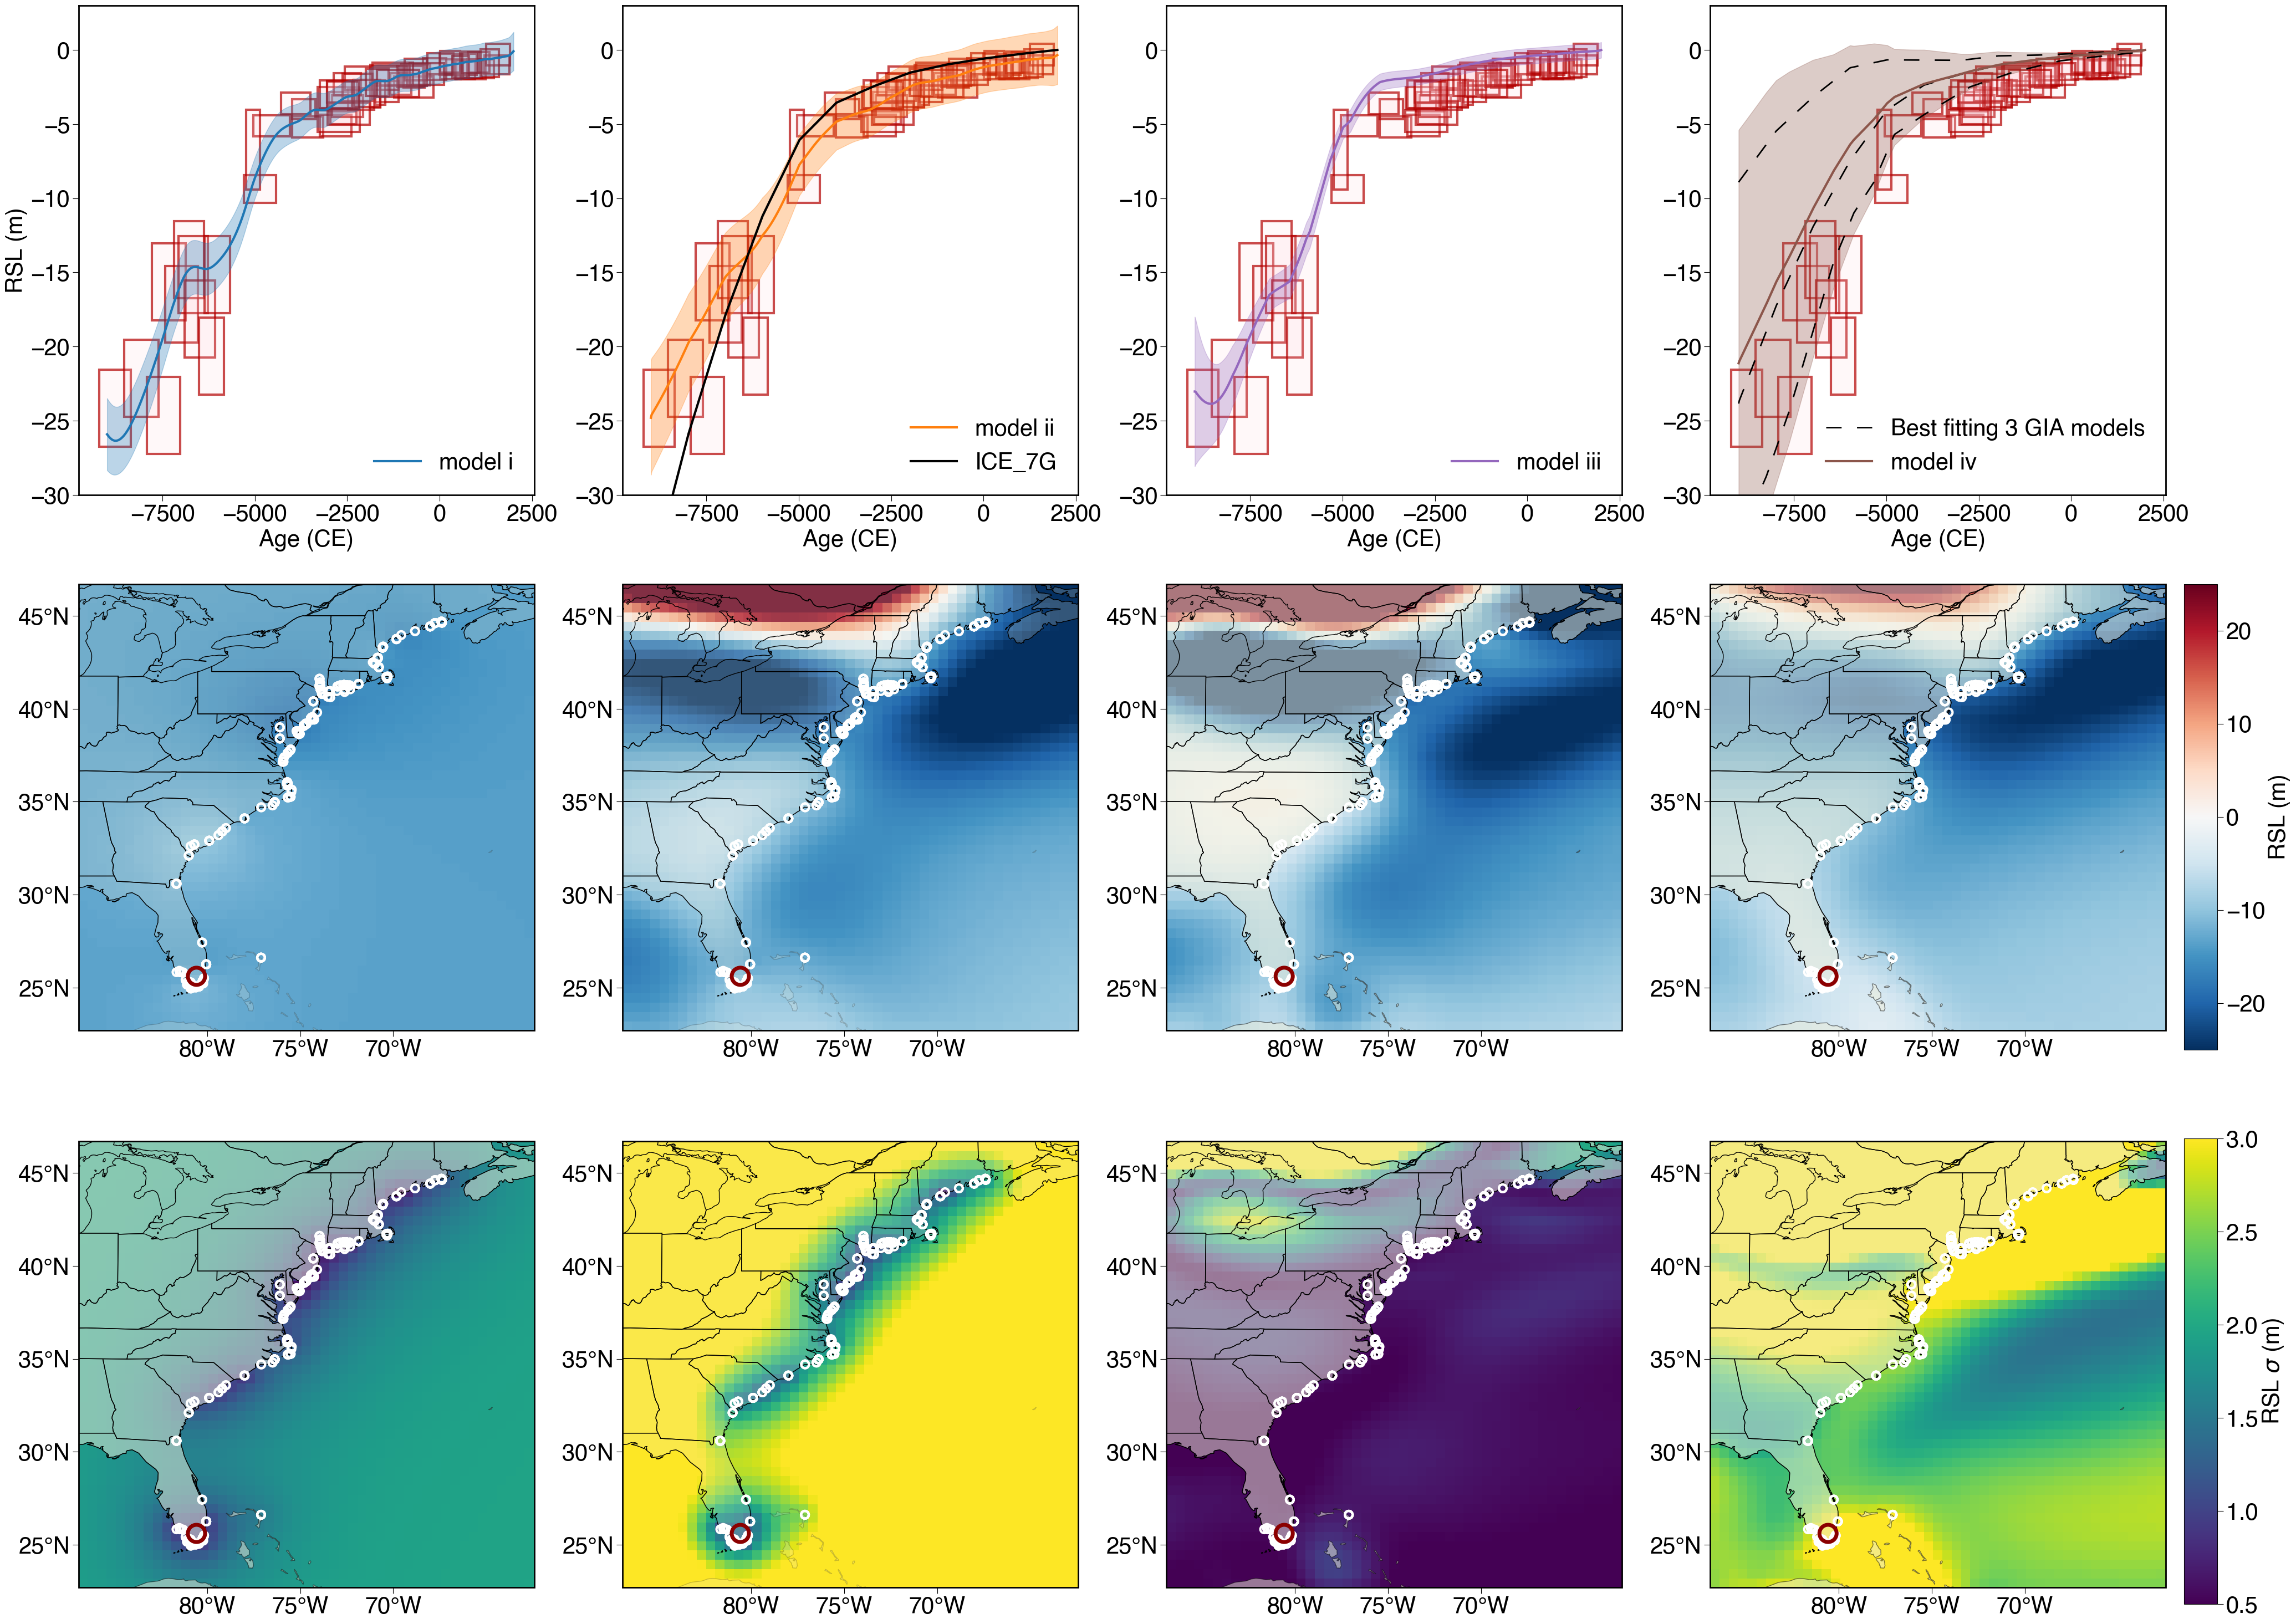

In [518]:
def thicken_frame(ax, linewidth=2):
    for spine in ax.spines.values():
        spine.set_linewidth(linewidth)

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()


plt.figure(figsize=(40,30))
ax1 = plt.subplot(341)
ax1.tick_params(axis='both', which='major', labelsize=30)

PSTHM.plotting.plot_uncertainty_boxes(X[:,0][site_index],y[site_index], age_sigma[site_index]*2,y_sigma[site_index]*2,ax=ax1,CE=True)
plt.plot(test_age,y_mean_1.detach().numpy(),'C0',linewidth=3,label='model i')
plt.fill_between(test_age,y_mean_1.detach().numpy()-1.645*y_std_1.detach().numpy(),y_mean_1.detach().numpy()+1.645*y_std_1.detach().numpy(),color='C0',alpha=0.3)
plt.ylim(-30,3)
plt.legend(loc=4,fontsize=30)
plt.ylabel('RSL (m)',fontsize=30)
thicken_frame(ax1)
plt.xlabel('Age (CE)',fontsize=30)

ax1 = plt.subplot(345,projection=ccrs.PlateCarree())
thicken_frame(ax1)

ax1.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.2)
ax1.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax1.pcolor(lon_mat,lat_mat,(y_mean_spa_1).reshape(lat_mat.shape),zorder=-1,vmax=25,vmin=-25,cmap='RdBu_r')

ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_xticks(np.arange(-70,-85,-5), crs=ccrs.PlateCarree())  
ax1.set_yticks(np.arange(25,50,5), crs=ccrs.PlateCarree())
ax1.scatter(rsl_lon,rsl_lat,ec='w',s=100,facecolor='none',zorder=1,linewidths=3)
ax1.scatter(np.mean(rsl_lon[site_index]),np.mean(rsl_lat[site_index]),ec='darkred',s=500,facecolor='none',zorder=1,linewidths=5)
ax1.tick_params(axis='both', which='major', labelsize=30)

ax2 = plt.subplot(349,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(y_std_spa_1).reshape(lat_mat.shape),zorder=-1,vmax=3,vmin=0.5)

ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xticks(np.arange(-70,-85,-5), crs=ccrs.PlateCarree())  
ax2.set_yticks(np.arange(25,50,5), crs=ccrs.PlateCarree())
ax2.scatter(rsl_lon,rsl_lat,ec='w',s=100,facecolor='none',zorder=1,linewidths=3)

ax2.scatter(np.mean(rsl_lon[site_index]),np.mean(rsl_lat[site_index]),ec='darkred',s=500,facecolor='none',zorder=1,linewidths=5)
ax2.tick_params(axis='both', which='major', labelsize=30)

thicken_frame(ax2)

ax2 = plt.subplot(342)
thicken_frame(ax2)
ax2.tick_params(axis='both', which='major', labelsize=30)

PSTHM.plotting.plot_uncertainty_boxes(X[:,0][site_index],y[site_index], age_sigma[site_index]*2,y_sigma[site_index]*2,ax=ax2,CE=True)
plt.xlabel('Age (CE)',fontsize=30)
plt.plot(test_age,y_combined.detach().numpy(),'C1',linewidth=3,label='model ii')
plt.fill_between(test_age,y_combined.detach().numpy()-1.645*y_std_2.detach().numpy(),y_combined.detach().numpy()+1.645*y_std_2.detach().numpy(),color='C1',alpha=0.3)
plt.plot(test_age,GIA_pred,'k',linewidth=3,label='ICE_7G')
plt.ylim(-30,3)
plt.legend(loc=4,fontsize=30)
plt.ylabel('')
ax2 = plt.subplot(346,projection=ccrs.PlateCarree())
thicken_frame(ax2)
ax2.scatter(rsl_lon,rsl_lat,ec='w',s=100,facecolor='none',zorder=1,linewidths=3)

ax2.scatter(np.mean(rsl_lon[site_index]),np.mean(rsl_lat[site_index]),ec='darkred',s=500,facecolor='none',zorder=1,linewidths=5)

cax = ax2.pcolor(lon_mat,lat_mat,y_combined_2.detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),vmax=25,vmin=-25,cmap='RdBu_r',zorder=-1)

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.2)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xticks(np.arange(-70,-85,-5), crs=ccrs.PlateCarree())  
ax2.set_yticks(np.arange(25,50,5), crs=ccrs.PlateCarree())
ax2.tick_params(axis='both', which='major', labelsize=30)

ax2 = plt.subplot(3,4,10,projection=ccrs.PlateCarree())
thicken_frame(ax2)

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.2)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xticks(np.arange(-70,-85,-5), crs=ccrs.PlateCarree())  
ax2.set_yticks(np.arange(25,50,5), crs=ccrs.PlateCarree())
cax = ax2.pcolor(lon_mat,lat_mat,y_std_spa_2.detach().numpy().reshape(lat_mat.shape),transform=ccrs.PlateCarree(),cmap='viridis',zorder=-1,vmax=3,vmin=0.5)
ax2.scatter(rsl_lon,rsl_lat,ec='w',s=100,facecolor='none',zorder=1,linewidths=3)

ax2.scatter(np.mean(rsl_lon[site_index]),np.mean(rsl_lat[site_index]),ec='darkred',s=500,facecolor='none',zorder=1,linewidths=5)
ax2.tick_params(axis='both', which='major', labelsize=30)

ax2 = plt.subplot(343)
thicken_frame(ax2)
ax2.tick_params(axis='both', which='major', labelsize=30)

PSTHM.plotting.plot_uncertainty_boxes(X[:,0][site_index],y[site_index], age_sigma[site_index]*2,y_sigma[site_index]*2,ax=ax2,CE=True)
plt.plot(test_age,y_mean_3.detach().numpy(),'C4',linewidth=3,label='model iii')
plt.fill_between(test_age,y_mean_3.detach().numpy()-1.645*y_std_3.detach().numpy(),y_mean_3.detach().numpy()+1.645*y_std_3.detach().numpy(),color='C4',alpha=0.3)
plt.legend(loc=4,fontsize=30)
plt.ylim(-30,3)
plt.ylabel('')
plt.xlabel('Age (CE)',fontsize=30)

ax2 = plt.subplot(347,projection=ccrs.PlateCarree())
thicken_frame(ax2)

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(y_mean_spa_3).detach().numpy().reshape(lat_mat.shape),zorder=-1,vmax=25,vmin=-25,cmap='RdBu_r')
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xticks(np.arange(-70,-85,-5), crs=ccrs.PlateCarree())  
ax2.set_yticks(np.arange(25,50,5), crs=ccrs.PlateCarree())
ax2.scatter(rsl_lon,rsl_lat,ec='w',s=100,facecolor='none',zorder=1,linewidths=3)

ax2.scatter(np.mean(rsl_lon[site_index]),np.mean(rsl_lat[site_index]),ec='darkred',s=500,facecolor='none',zorder=1,linewidths=5)
ax2.tick_params(axis='both', which='major', labelsize=30)

ax2 = plt.subplot(3,4,11,projection=ccrs.PlateCarree())
thicken_frame(ax2)
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im = ax2.pcolor(lon_mat,lat_mat,(y_std_spa_3).detach().numpy().reshape(lat_mat.shape),zorder=-1,vmax=3,vmin=0.5)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xticks(np.arange(-70,-85,-5), crs=ccrs.PlateCarree())  
ax2.set_yticks(np.arange(25,50,5), crs=ccrs.PlateCarree())
ax2.scatter(rsl_lon,rsl_lat,ec='w',s=100,facecolor='none',zorder=1,linewidths=3)

ax2.scatter(np.mean(rsl_lon[site_index]),np.mean(rsl_lat[site_index]),ec='darkred',s=500,facecolor='none',zorder=1,linewidths=5)
ax2.tick_params(axis='both', which='major', labelsize=30)


ax2 = plt.subplot(344)
thicken_frame(ax2)
ax2.tick_params(axis='both', which='major', labelsize=30)

PSTHM.plotting.plot_uncertainty_boxes(X[:,0][site_index],y[site_index], age_sigma[site_index]*2,y_sigma[site_index]*2,ax=ax2,CE=True)
plt.fill_between(test_age,mean_pred-1.645*std_pred,mean_pred+1.645*std_pred,color='C5',alpha=0.3)
plt.ylim(-30,3)

for i in range(6,9):
    if i==6:
        plt.plot(test_age,model_ensemble[i](pred_matrix),label='Best fitting 3 GIA models',color='k',linewidth=2,linestyle='--', dashes=(10, 10))
    else:
        plt.plot(test_age,model_ensemble[i](pred_matrix),color='k',linewidth=2,linestyle='--', dashes=(10, 10))
plt.plot(test_age,mean_pred,'C5',linewidth=3,label='model iv')
plt.xlabel('Age (CE)',fontsize=30)

plt.legend(loc=4,fontsize=30)
plt.ylabel('')
ax2 = plt.subplot(3,4,8,projection=ccrs.PlateCarree())
thicken_frame(ax2)
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im6 = ax2.pcolor(lon_mat,lat_mat,(mean_pred_spa).reshape(lat_mat.shape),zorder=-1,vmax=25,vmin=-25,cmap='RdBu_r')
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xticks(np.arange(-70,-85,-5), crs=ccrs.PlateCarree())  
ax2.set_yticks(np.arange(25,50,5), crs=ccrs.PlateCarree())
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.scatter(rsl_lon,rsl_lat,ec='w',s=100,facecolor='none',zorder=1,linewidths=3)

ax2.scatter(np.mean(rsl_lon[site_index]),np.mean(rsl_lat[site_index]),ec='darkred',s=500,facecolor='none',zorder=1,linewidths=5)

ax2 = plt.subplot(3,4,12,projection=ccrs.PlateCarree())
thicken_frame(ax2)
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
im7 = ax2.pcolor(lon_mat,lat_mat,(std_pred_spa).reshape(lat_mat.shape),zorder=-1,vmax=3,vmin=0.5)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xticks(np.arange(-70,-85,-5), crs=ccrs.PlateCarree())  
ax2.set_yticks(np.arange(25,50,5), crs=ccrs.PlateCarree())
ax2.tick_params(axis='both', which='major', labelsize=30)

ax2.scatter(rsl_lon,rsl_lat,ec='w',s=100,facecolor='none',zorder=1,linewidths=3)
ax2.scatter(np.mean(rsl_lon[site_index]),np.mean(rsl_lat[site_index]),ec='darkred',s=500,facecolor='none',zorder=1,linewidths=5)


cbar_ax = plt.gcf().add_axes([0.99, 0.362, 0.015, 0.28])  # adjust the dimensions as needed
cbar1 = plt.colorbar(im6, cax=cbar_ax,label='RSL (m)')
cbar1.ax.tick_params(labelsize=30)  # Set tick font size
cbar1.set_label('RSL (m)', size=30)  # Set label and its font size

# Third row, spatial plots not shown for brevity, but similar approach

# Add the colorbar code here for the third row, similar to above
# plt.subplots_adjust(right=0.85)
cbar_ax2 = plt.gcf().add_axes([0.99, 0.0285, 0.015, 0.28])  # adjust the dimensions as needed
cbar2 = plt.colorbar(im7, cax=cbar_ax2)  # Assuming 'im6' type data; replace with correct image handle as needed
cbar2.ax.tick_params(labelsize=30)  # Set tick font size
cbar2.set_label('RSL $\sigma$ (m)', size=30)  # Set label and its font size
plt.tight_layout()

# plt.savefig('method_comparison.pdf',dpi=300)


Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.